<a href="https://colab.research.google.com/github/dudu1626/projeto-metodologia/blob/main/An%C3%A1lise_dos_resultados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bibliotecas e configuração

In [ ]:
# dados
import pandas as pd
import numpy as np
# estatística
from scipy.stats import shapiro, kruskal, rankdata, kstest
from scipy import stats
# visualização
import matplotlib.pyplot as plt
import seaborn as sns
# outros
from itertools import combinations

In [ ]:
# configuração pandas
pd.set_option('display.max_columns', None)
#configuração matplotlib seaborn
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_theme(style="darkgrid")

## Carregamento dos dados e limpeza

In [ ]:
# Carregar os dados do Excel
xls = pd.ExcelFile("resultados consolidados de treino.xlsx")
df = xls.parse("emissões treino")
df.head(2)

,Arquitetura,Limitação (%),Execução,modelo,timestamp,project_name,run_id,experiment_id,duration,emissions,emissions_rate,cpu_power,gpu_power,ram_power,cpu_energy,gpu_energy,ram_energy,energy_consumed,country_name,country_iso_code,region,cloud_provider,cloud_region,os,python_version,codecarbon_version,cpu_count,cpu_model,gpu_count,gpu_model,longitude,latitude,ram_total_size,tracking_mode,on_cloud,pue,arquivo_origem,Média Perda Treino,Média Acurácia Treino,Média Perda Validação,Média Acurácia Validação
0,AlexNet,70,1,alexnet-70,2025-07-11T15:48:53,codecarbon,6e2f8b02-4331-4652-bbac-9e5b27e4023a,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,39.166152,0.000135,0.000003,42.5,75.852928,10,0.000462,0.000804,0.000109,0.001375,Brazil,BRA,rio de janeiro,NaN,NaN,Linux-6.8.0-62-generic-x86_64-with-glibc2.39,3.12.11,3.0.2,20,13th Gen Intel(R) Core(TM) i7-13650HX,1,1 x NVIDIA GeForce RTX 3050 6GB Laptop GPU,-43.1883,-22.9072,15.3074,machine,N,1,emissoes_treino_modelo_1.csv,1.019788,0.628375,0.631657,0.762417
1,AlexNet,70,2,alexnet-70,2025-07-11T15:49:38,codecarbon,9768669f-1274-43b8-9ae8-6a1611be1b00,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,39.142986,0.000137,0.000003,42.5,75.721854,10,0.000462,0.000818,0.000109,0.001389,Brazil,BRA,rio de janeiro,NaN,NaN,Linux-6.8.0-62-generic-x86_64-with-glibc2.39,3.12.11,3.0.2,20,13th Gen Intel(R) Core(TM) i7-13650HX,1,1 x NVIDIA GeForce RTX 3050 6GB Laptop GPU,-43.1883,-22.9072,15.3074,machine,N,1,emissoes_treino_modelo_2.csv,1.015383,0.632333,0.634976,0.762833


In [ ]:
# Selecionar e limpar os dados
dados = df[['Arquitetura', 'Limitação (%)', 'Execução', 'duration', 'energy_consumed', 'emissions', 'Média Acurácia Validação']].copy()
dados.columns = ['Arquitetura', 'Limite', 'Execucao', 'Duracao', 'Energia_kWh', 'Emissao_kgCO2', 'Acuracia']
# dados['Energia_kWh'] = dados['Energia_kWh'] * 1000 # transformação de Kw/H para W/h
# dados['Emissao_kgCO2'] = dados['Emissao_kgCO2'] * 1000 # Transformação de KG de CO2 para g de CO2

# Cálculo dos índices de eficiência
dados['Eficiencia_Energia'] = dados['Acuracia'] / dados['Energia_kWh']
dados['Eficiencia_Emissao'] = dados['Acuracia'] / dados['Emissao_kgCO2']

dados.head(2)
dados

,Arquitetura,Limite,Execucao,Duracao,Energia_kWh,Emissao_kgCO2,Acuracia,Eficiencia_Energia,Eficiencia_Emissao
0,AlexNet,70,1,39.166152,0.001375,0.000135,0.762417,554.590133,5639.058582
1,AlexNet,70,2,39.142986,0.001389,0.000137,0.762833,549.141987,5583.661965
2,AlexNet,70,3,39.129949,0.001382,0.000136,0.761944,551.135296,5603.929883
3,AlexNet,70,4,39.130473,0.001395,0.000137,0.760146,544.960122,5541.140865
4,AlexNet,70,5,39.132319,0.001393,0.000137,0.758967,544.813027,5539.645208
...,...,...,...,...,...,...,...,...,...
355,VGG16,95,6,708.370765,0.018113,0.000043,0.903486,49.880472,20982.702719
356,VGG16,95,7,763.063727,0.019509,0.000046,0.903726,46.323871,19486.584186
357,VGG16,95,8,599.767918,0.015343,0.001509,0.901958,58.784942,597.723822
358,VGG16,95,9,654.043578,0.016741,0.000040,0.902046,53.881074,22665.594389


## Funções auxiliares

### Colorir células no teste de hipótese

In [ ]:
# Função para colorir as células pandas
def colorir_celula(value):
    if isinstance(value, (int, float)):
        if value <= 0.05:
            return 'background-color: green'
        else:
            return 'background-color: red'
    return '' # Retorna string vazia para não aplicar estilo a outros tipos de dados

### Pós-Teste de Dunn

In [ ]:
# Teste de Dunn com correção de Holm
def dunn_posthoc_test(data, groups):
    unique_groups = np.unique(groups)
    k = len(unique_groups)
    N = len(data)

    ranks = rankdata(data)
    group_ranks = {g: ranks[groups == g] for g in unique_groups}
    n_i = {g: len(group_ranks[g]) for g in unique_groups}
    R_i = {g: np.sum(group_ranks[g]) for g in unique_groups}

    comparisons = list(combinations(unique_groups, 2))
    z_vals = []
    p_vals = []

    for g1, g2 in comparisons:
        n1, n2 = n_i[g1], n_i[g2]
        R1, R2 = R_i[g1], R_i[g2]
        mean_rank_diff = abs(R1 / n1 - R2 / n2)
        denom = np.sqrt((N * (N + 1)) / 12 * (1 / n1 + 1 / n2))
        z = mean_rank_diff / denom
        p = 2 * (1 - stats.norm.cdf(z))
        z_vals.append(z)
        p_vals.append(p)

    # Correção de Holm
    p_vals_np = np.array(p_vals)
    sorted_idx = np.argsort(p_vals_np)
    corrected = np.empty_like(p_vals_np)
    m = len(p_vals)
    for i, idx in enumerate(sorted_idx):
        corrected[idx] = min((m - i) * p_vals_np[idx], 1.0)

    result = pd.DataFrame(index=unique_groups, columns=unique_groups, dtype=float)
    for (g1, g2), pval in zip(comparisons, corrected):
        result.loc[g1, g2] = result.loc[g2, g1] = pval
    np.fill_diagonal(result.values, np.nan)
    return result

## Análise da acurácia

In [ ]:
# Obter arquiteturas
arquiteturas = dados['Arquitetura'].unique()
acuracias_por_arquitetura = [dados[dados['Arquitetura'] == arq]['Acuracia'].values for arq in arquiteturas]

In [ ]:
# Teste de normalidade (Kolmogorov-Smirnov)
normalidade = {arq: kstest(valores, 'norm').pvalue for arq, valores in zip(arquiteturas, acuracias_por_arquitetura)}
print("Resultados do teste de normalidade (Kolmogorov-Smirnov):")
normalidade

Resultados do teste de normalidade (Kolmogorov-Smirnov):


{'AlexNet': np.float64(1.4501037543358562e-38),
 'GoogleNet': np.float64(7.287503417515803e-38),
 'LeNet': np.float64(1.2179757416538804e-36),
 'MobileNet': np.float64(7.75447067467003e-37),
 'ResNet': np.float64(4.204876072552167e-42),
 'VGG16': np.float64(7.171051974738416e-43)}

In [ ]:
for id, p_valor in normalidade.items():
    if p_valor > 0.05:
        print(f"A arquitetura {id} segue uma distribuição normal.")
    else:
        print(f"A arquitetura {id} NÃO segue uma distribuição normal.")

A arquitetura AlexNet NÃO segue uma distribuição normal.
A arquitetura GoogleNet NÃO segue uma distribuição normal.
A arquitetura LeNet NÃO segue uma distribuição normal.
A arquitetura MobileNet NÃO segue uma distribuição normal.
A arquitetura ResNet NÃO segue uma distribuição normal.
A arquitetura VGG16 NÃO segue uma distribuição normal.


In [ ]:
# Teste de Kruskal-Wallis
kruskal_result = kruskal(*acuracias_por_arquitetura)
print("\nResultado do teste de Kruskal-Wallis:")
print(f"Estatística H = {kruskal_result.statistic:.2f} e p-valor = {kruskal_result.pvalue}.")


Resultado do teste de Kruskal-Wallis:
Estatística H = 170.28 e p-valor = 6.353308719292498e-35.


In [ ]:
# Aplicar teste de Dunn
valores = dados['Acuracia'].values
grupos = dados['Arquitetura'].values
dunn_result = dunn_posthoc_test(valores, grupos)

print("\nTeste de Dunn (correção Holm) - p-valores entre pares:")
dunn_result.style.map(colorir_celula)


Teste de Dunn (correção Holm) - p-valores entre pares:


,AlexNet,GoogleNet,LeNet,MobileNet,ResNet,VGG16
AlexNet,nan,0.259476,0.092221,0.000000,0.218017,0.001120
GoogleNet,0.259476,nan,0.438183,0.000000,0.013710,0.000009
LeNet,0.092221,0.438183,nan,0.000000,0.000150,0.000000
MobileNet,0.000000,0.000000,0.000000,nan,0.000000,0.000000
ResNet,0.218017,0.013710,0.000150,0.000000,nan,0.191994
VGG16,0.001120,0.000009,0.000000,0.000000,0.191994,nan


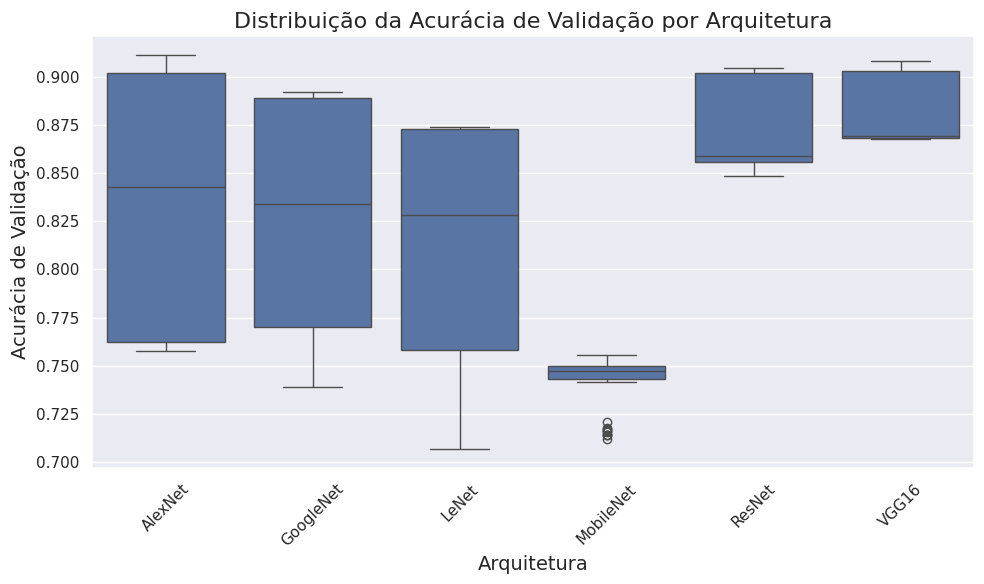

In [ ]:
# Visualização: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=dados, x='Arquitetura', y='Acuracia')
plt.title("Distribuição da Acurácia de Validação por Arquitetura", fontsize=16)
plt.xlabel("Arquitetura", fontsize=14)
plt.ylabel("Acurácia de Validação", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Análise duração

In [ ]:
# Obter arquiteturas
duracao_por_arquitetura = [dados[dados['Arquitetura'] == arq]['Duracao'].values for arq in arquiteturas]

In [ ]:
# Teste de normalidade (Kolmogorov-Smirnov)
normalidade = {arq: kstest(valores, 'norm').pvalue for arq, valores in zip(arquiteturas, duracao_por_arquitetura)}
print("Resultados do teste de normalidade (Kolmogorov-Smirnov):")
normalidade

Resultados do teste de normalidade (Kolmogorov-Smirnov):


{'AlexNet': np.float64(0.0),
 'GoogleNet': np.float64(0.0),
 'LeNet': np.float64(0.0),
 'MobileNet': np.float64(0.0),
 'ResNet': np.float64(0.0),
 'VGG16': np.float64(0.0)}

In [ ]:
for id, p_valor in normalidade.items():
    if p_valor > 0.05:
        print(f"A arquitetura {id} segue uma distribuição normal.")
    else:
        print(f"A arquitetura {id} NÃO segue uma distribuição normal.")

A arquitetura AlexNet NÃO segue uma distribuição normal.
A arquitetura GoogleNet NÃO segue uma distribuição normal.
A arquitetura LeNet NÃO segue uma distribuição normal.
A arquitetura MobileNet NÃO segue uma distribuição normal.
A arquitetura ResNet NÃO segue uma distribuição normal.
A arquitetura VGG16 NÃO segue uma distribuição normal.


In [ ]:
# Teste de Kruskal-Wallis
kruskal_result = kruskal(*duracao_por_arquitetura)
print("\nResultado do teste de Kruskal-Wallis:")
print(f"Estatística H = {kruskal_result.statistic:.2f} e p-valor = {kruskal_result.pvalue}.")


Resultado do teste de Kruskal-Wallis:
Estatística H = 60.99 e p-valor = 7.581466614642108e-12.


In [ ]:
# Aplicar teste de Dunn
valores = dados['Duracao'].values
grupos = dados['Arquitetura'].values
dunn_result = dunn_posthoc_test(valores, grupos)

print("\nTeste de Dunn (correção Holm) - p-valores entre pares:")
dunn_result.style.map(colorir_celula)


Teste de Dunn (correção Holm) - p-valores entre pares:


,AlexNet,GoogleNet,LeNet,MobileNet,ResNet,VGG16
AlexNet,nan,0.441716,0.000074,0.125049,0.445444,0.517550
GoogleNet,0.441716,nan,0.001813,0.015324,0.109235,1.000000
LeNet,0.000074,0.001813,nan,0.000000,0.000000,0.029028
MobileNet,0.125049,0.015324,0.000000,nan,0.875125,0.000771
ResNet,0.445444,0.109235,0.000000,0.875125,nan,0.012811
VGG16,0.517550,1.000000,0.029028,0.000771,0.012811,nan


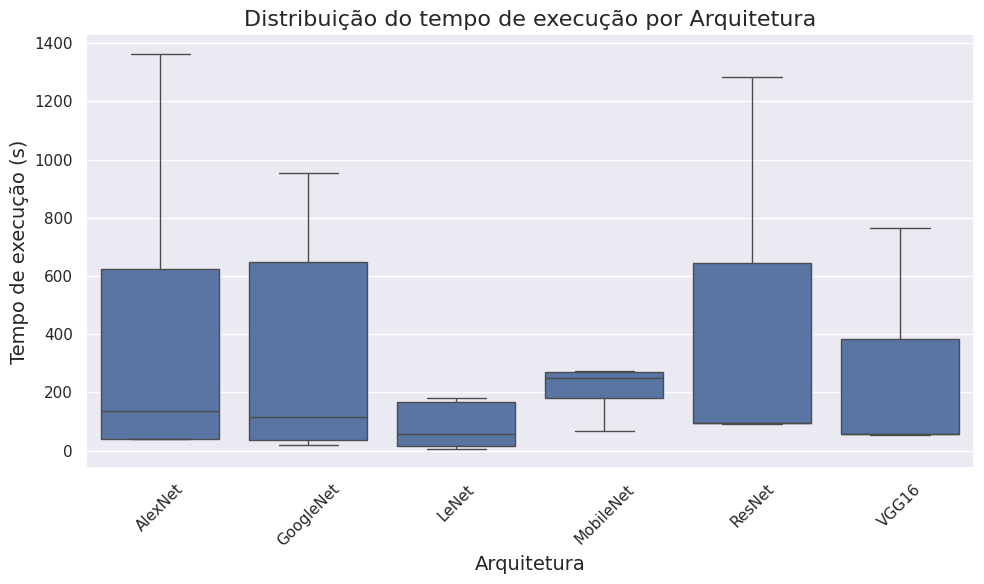

In [ ]:
# Visualização: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=dados, x='Arquitetura', y='Duracao')
plt.title("Distribuição do tempo de execução por Arquitetura", fontsize=16)
plt.xlabel("Arquitetura", fontsize=14)
plt.ylabel("Tempo de execução (s)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Análise consumo de energia

In [ ]:
dados.head(2)

,Arquitetura,Limite,Execucao,Duracao,Energia_kWh,Emissao_kgCO2,Acuracia,Eficiencia_Energia,Eficiencia_Emissao
0,AlexNet,70,1,39.166152,0.001375,0.000135,0.762417,554.590133,5639.058582
1,AlexNet,70,2,39.142986,0.001389,0.000137,0.762833,549.141987,5583.661965


In [ ]:
# Obter arquiteturas
energia_por_arquitetura = [dados[dados['Arquitetura'] == arq]['Energia_kWh'].values for arq in arquiteturas]

In [ ]:
# Teste de normalidade (Kolmogorov-Smirnov)
normalidade = {arq: kstest(valores, 'norm').pvalue for arq, valores in zip(arquiteturas, energia_por_arquitetura)}
print("Resultados do teste de normalidade (Kolmogorov-Smirnov):")
normalidade

Resultados do teste de normalidade (Kolmogorov-Smirnov):


{'AlexNet': np.float64(2.0290561897793396e-14),
 'GoogleNet': np.float64(2.0850839326419338e-14),
 'LeNet': np.float64(2.122233081077291e-14),
 'MobileNet': np.float64(1.9377730008790315e-14),
 'ResNet': np.float64(1.870818850150501e-14),
 'VGG16': np.float64(1.9839464302438592e-14)}

In [ ]:
for id, p_valor in normalidade.items():
    if p_valor > 0.05:
        print(f"A arquitetura {id} segue uma distribuição normal.")
    else:
        print(f"A arquitetura {id} NÃO segue uma distribuição normal.")

A arquitetura AlexNet NÃO segue uma distribuição normal.
A arquitetura GoogleNet NÃO segue uma distribuição normal.
A arquitetura LeNet NÃO segue uma distribuição normal.
A arquitetura MobileNet NÃO segue uma distribuição normal.
A arquitetura ResNet NÃO segue uma distribuição normal.
A arquitetura VGG16 NÃO segue uma distribuição normal.


In [ ]:
# Teste de Kruskal-Wallis
kruskal_result = kruskal(*energia_por_arquitetura)
print("\nResultado do teste de Kruskal-Wallis:")
print(f"Estatística H = {kruskal_result.statistic:.2f} e p-valor = {kruskal_result.pvalue}.")


Resultado do teste de Kruskal-Wallis:
Estatística H = 78.65 e p-valor = 1.605239261400689e-15.


In [ ]:
# Aplicar teste de Dunn
valores = dados['Energia_kWh'].values
grupos = dados['Arquitetura'].values
dunn_result = dunn_posthoc_test(valores, grupos)

print("\nTeste de Dunn (correção Holm) - p-valores entre pares:")
dunn_result.style.map(colorir_celula)


Teste de Dunn (correção Holm) - p-valores entre pares:


,AlexNet,GoogleNet,LeNet,MobileNet,ResNet,VGG16
AlexNet,nan,1.000000,0.000001,0.078481,0.477904,0.439173
GoogleNet,1.000000,nan,0.000078,0.006202,0.069371,0.492182
LeNet,0.000001,0.000078,nan,0.000000,0.000000,0.001324
MobileNet,0.078481,0.006202,0.000000,nan,0.830245,0.000494
ResNet,0.477904,0.069371,0.000000,0.830245,nan,0.008733
VGG16,0.439173,0.492182,0.001324,0.000494,0.008733,nan


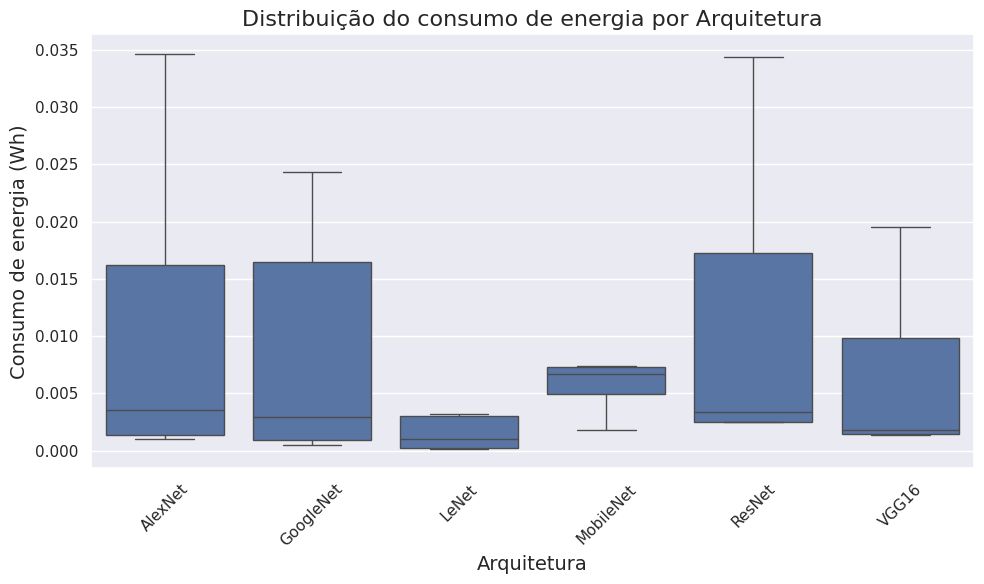

In [ ]:
# Visualização: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=dados, x='Arquitetura', y='Energia_kWh')
plt.title("Distribuição do consumo de energia por Arquitetura", fontsize=16)
plt.xlabel("Arquitetura", fontsize=14)
plt.ylabel("Consumo de energia (Wh)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Análise com as limitações

In [ ]:
# análise to tempo de execução, considerando as arquiteturas com mesmas limitações
dados.groupby(dados['Limite'])[['Duracao', 'Energia_kWh', 'Emissao_kgCO2', 'Acuracia']].mean()

,Duracao,Energia_kWh,Emissao_kgCO2,Acuracia
Limite,,,,
70,51.400421,0.001702,0.000167,0.776547
75,71.814920,0.001879,0.000177,0.793493
80,98.296493,0.002544,0.000250,0.817245
85,149.108651,0.003779,0.000314,0.840717
90,495.033107,0.012811,0.001225,0.870018
95,685.401031,0.017620,0.001092,0.871447


In [ ]:
# Agrupar por Arquitetura e Limitação (%) e calcular a média
dados_agrupados = dados.groupby(['Arquitetura', 'Limite'])[['Duracao', 'Energia_kWh', 'Emissao_kgCO2', 'Acuracia']].mean()
dados_agrupados

Duracao  Energia_kWh  Emissao_kgCO2  Acuracia
Arquitetura Limite                                                   
AlexNet     70        39.138051     0.001388       0.000137  0.759890
            75        44.039134     0.001119       0.000110  0.760495
            80        83.023949     0.002130       0.000209  0.816355
            85       203.722754     0.005251       0.000235  0.856662
            90       627.885149     0.016893       0.001661  0.901865
            95      1156.680161     0.029817       0.002009  0.908440
GoogleNet   70        19.308648     0.000687       0.000068  0.747065
            75        29.820142     0.000743       0.000073  0.772708
            80        62.125464     0.001568       0.000154  0.810994
            85       182.158872     0.004618       0.000454  0.855752
            90       799.120963     0.020378       0.001794  0.890389
            95       799.125393     0.020282       0.000907  0.890389
LeNet       70         6.636494     0.000184       0.000018  0.712781
            75        14.911221     0.000264       0.000026  0.758600
            80        32.788588     0.000598       0.000059  0.803411
            85        90.215489     0.001640       0.000161  0.852324
            90       168.173189     0.003071       0.000302  0.873122
            95       166.881676     0.003075       0.000273  0.873122
MobileNet   70        95.763311     0.002612       0.000257  0.715820
            75       192.556491     0.005225       0.000466  0.745432
            80       260.369248     0.007033       0.000692  0.748985
            85       259.885665     0.007002       0.000625  0.748985
            90       259.967101     0.007030       0.000691  0.748985
            95       260.026431     0.007016       0.000344  0.748985
ResNet      70        92.768045     0.003392       0.000334  0.854812
            75        93.751539     0.002499       0.000246  0.854812
            80        93.764873     0.002491       0.000245  0.854812
            85       102.884916     0.002743       0.000270  0.861670
            90       716.922632     0.019220       0.001890  0.902057
            95      1092.041965     0.029214       0.002378  0.903859
VGG16       70        54.787977     0.001948       0.000192  0.868911
            75        55.810991     0.001421       0.000140  0.868911
            80        57.706837     0.001443       0.000142  0.868911
            85        55.784211     0.001418       0.000139  0.868911
            90       398.129609     0.010273       0.001010  0.903687
            95       637.650558     0.016316       0.000641  0.903887

In [ ]:
dados.head(2)

,Arquitetura,Limite,Execucao,Duracao,Energia_kWh,Emissao_kgCO2,Acuracia,Eficiencia_Energia,Eficiencia_Emissao
0,AlexNet,70,1,39.166152,0.001375,0.000135,0.762417,554.590133,5639.058582
1,AlexNet,70,2,39.142986,0.001389,0.000137,0.762833,549.141987,5583.661965


In [ ]:
# separação dos dados por limitação
dados_70 = dados[dados['Limite'] == 70]
dados_75 = dados[dados['Limite'] == 75]
dados_80 = dados[dados['Limite'] == 80]
dados_85 = dados[dados['Limite'] == 85]
dados_90 = dados[dados['Limite'] == 90]
dados_95 = dados[dados['Limite'] == 95]

In [ ]:
# Agrupar por Arquitetura e Limitação (%) e calcular a média
dados_agrupados_70 = dados_70.groupby(['Arquitetura', 'Limite'])[['Duracao', 'Energia_kWh', 'Emissao_kgCO2', 'Acuracia']].mean()
dados_agrupados_75 = dados_75.groupby(['Arquitetura', 'Limite'])[['Duracao', 'Energia_kWh', 'Emissao_kgCO2', 'Acuracia']].mean()
dados_agrupados_80 = dados_80.groupby(['Arquitetura', 'Limite'])[['Duracao', 'Energia_kWh', 'Emissao_kgCO2', 'Acuracia']].mean()
dados_agrupados_85 = dados_85.groupby(['Arquitetura', 'Limite'])[['Duracao', 'Energia_kWh', 'Emissao_kgCO2', 'Acuracia']].mean()
dados_agrupados_90 = dados_90.groupby(['Arquitetura', 'Limite'])[['Duracao', 'Energia_kWh', 'Emissao_kgCO2', 'Acuracia']].mean()
dados_agrupados_95 = dados_95.groupby(['Arquitetura', 'Limite'])[['Duracao', 'Energia_kWh', 'Emissao_kgCO2', 'Acuracia']].mean()

In [ ]:
dados_agrupados_70

,,Duracao,Energia_kWh,Emissao_kgCO2,Acuracia
Arquitetura,Limite,,,,
AlexNet,70,39.138051,0.001388,0.000137,0.759890
GoogleNet,70,19.308648,0.000687,0.000068,0.747065
LeNet,70,6.636494,0.000184,0.000018,0.712781
MobileNet,70,95.763311,0.002612,0.000257,0.715820
ResNet,70,92.768045,0.003392,0.000334,0.854812
VGG16,70,54.787977,0.001948,0.000192,0.868911


In [ ]:
dados_agrupados_75

,,Duracao,Energia_kWh,Emissao_kgCO2,Acuracia
Arquitetura,Limite,,,,
AlexNet,75,44.039134,0.001119,0.000110,0.760495
GoogleNet,75,29.820142,0.000743,0.000073,0.772708
LeNet,75,14.911221,0.000264,0.000026,0.758600
MobileNet,75,192.556491,0.005225,0.000466,0.745432
ResNet,75,93.751539,0.002499,0.000246,0.854812
VGG16,75,55.810991,0.001421,0.000140,0.868911


In [ ]:
dados_agrupados_80

,,Duracao,Energia_kWh,Emissao_kgCO2,Acuracia
Arquitetura,Limite,,,,
AlexNet,80,83.023949,0.002130,0.000209,0.816355
GoogleNet,80,62.125464,0.001568,0.000154,0.810994
LeNet,80,32.788588,0.000598,0.000059,0.803411
MobileNet,80,260.369248,0.007033,0.000692,0.748985
ResNet,80,93.764873,0.002491,0.000245,0.854812
VGG16,80,57.706837,0.001443,0.000142,0.868911


In [ ]:
dados_agrupados_85

,,Duracao,Energia_kWh,Emissao_kgCO2,Acuracia
Arquitetura,Limite,,,,
AlexNet,85,203.722754,0.005251,0.000235,0.856662
GoogleNet,85,182.158872,0.004618,0.000454,0.855752
LeNet,85,90.215489,0.001640,0.000161,0.852324
MobileNet,85,259.885665,0.007002,0.000625,0.748985
ResNet,85,102.884916,0.002743,0.000270,0.861670
VGG16,85,55.784211,0.001418,0.000139,0.868911


In [ ]:
dados_agrupados_90

,,Duracao,Energia_kWh,Emissao_kgCO2,Acuracia
Arquitetura,Limite,,,,
AlexNet,90,627.885149,0.016893,0.001661,0.901865
GoogleNet,90,799.120963,0.020378,0.001794,0.890389
LeNet,90,168.173189,0.003071,0.000302,0.873122
MobileNet,90,259.967101,0.007030,0.000691,0.748985
ResNet,90,716.922632,0.019220,0.001890,0.902057
VGG16,90,398.129609,0.010273,0.001010,0.903687


In [ ]:
dados_agrupados_95

,,Duracao,Energia_kWh,Emissao_kgCO2,Acuracia
Arquitetura,Limite,,,,
AlexNet,95,1156.680161,0.029817,0.002009,0.908440
GoogleNet,95,799.125393,0.020282,0.000907,0.890389
LeNet,95,166.881676,0.003075,0.000273,0.873122
MobileNet,95,260.026431,0.007016,0.000344,0.748985
ResNet,95,1092.041965,0.029214,0.002378,0.903859
VGG16,95,637.650558,0.016316,0.000641,0.903887


## Análise - 70%

### Duração

In [ ]:
# Obter arquiteturas
duracao_por_arquitetura = [dados_70[dados_70['Arquitetura'] == arq]['Duracao'].values for arq in arquiteturas]

In [ ]:
# Teste de normalidade (Kolmogorov-Smirnov)
normalidade = {arq: kstest(valores, 'norm').pvalue for arq, valores in zip(arquiteturas, duracao_por_arquitetura)}
print("Resultados do teste de normalidade (Kolmogorov-Smirnov):")
normalidade

Resultados do teste de normalidade (Kolmogorov-Smirnov):


{'AlexNet': np.float64(0.0),
 'GoogleNet': np.float64(0.0),
 'LeNet': np.float64(6.5119451482949854e-105),
 'MobileNet': np.float64(0.0),
 'ResNet': np.float64(0.0),
 'VGG16': np.float64(0.0)}

In [ ]:
for id, p_valor in normalidade.items():
    if p_valor > 0.05:
        print(f"A arquitetura {id} segue uma distribuição normal.")
    else:
        print(f"A arquitetura {id} NÃO segue uma distribuição normal.")

A arquitetura AlexNet NÃO segue uma distribuição normal.
A arquitetura GoogleNet NÃO segue uma distribuição normal.
A arquitetura LeNet NÃO segue uma distribuição normal.
A arquitetura MobileNet NÃO segue uma distribuição normal.
A arquitetura ResNet NÃO segue uma distribuição normal.
A arquitetura VGG16 NÃO segue uma distribuição normal.


In [ ]:
# Teste de Kruskal-Wallis
kruskal_result = kruskal(*duracao_por_arquitetura)
print("\nResultado do teste de Kruskal-Wallis:")
print(f"Estatística H = {kruskal_result.statistic:.2f} e p-valor = {kruskal_result.pvalue}.")


Resultado do teste de Kruskal-Wallis:
Estatística H = 56.00 e p-valor = 8.126561126719025e-11.


In [ ]:
# Aplicar teste de Dunn
valores = dados_70['Duracao'].values
grupos = dados_70['Arquitetura'].values
dunn_result = dunn_posthoc_test(valores, grupos)

print("\nTeste de Dunn (correção Holm) - p-valores entre pares:")
dunn_result.style.map(colorir_celula)


Teste de Dunn (correção Holm) - p-valores entre pares:


,AlexNet,GoogleNet,LeNet,MobileNet,ResNet,VGG16
AlexNet,nan,0.801662,0.083560,0.029080,0.005462,0.601246
GoogleNet,0.801662,nan,0.400831,0.000286,0.000028,0.073115
LeNet,0.083560,0.400831,nan,0.000001,0.000000,0.001347
MobileNet,0.029080,0.000286,0.000001,nan,0.608548,0.480083
ResNet,0.005462,0.000028,0.000000,0.608548,nan,0.177050
VGG16,0.601246,0.073115,0.001347,0.480083,0.177050,nan


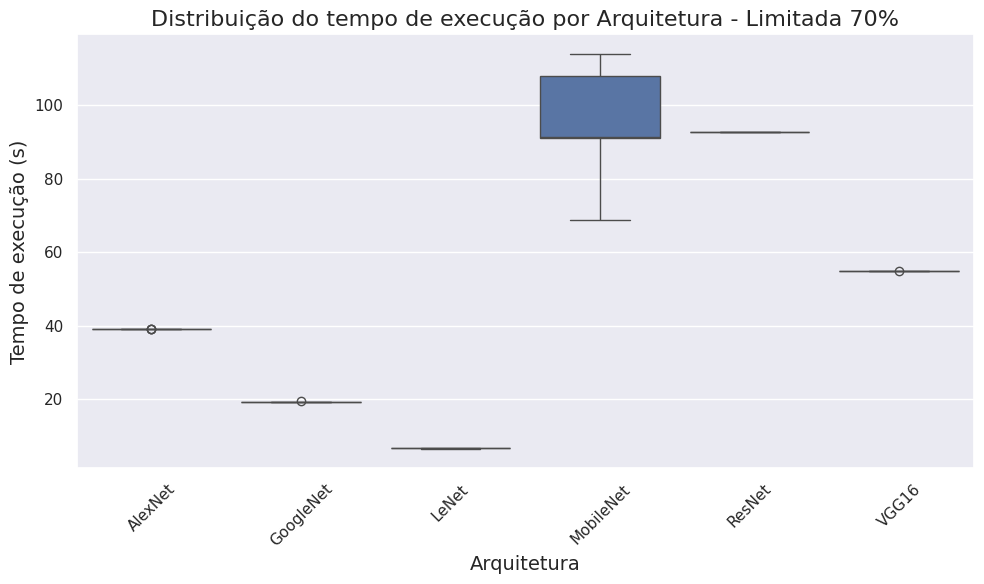

In [ ]:
# Visualização: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=dados_70, x='Arquitetura', y='Duracao')
plt.title("Distribuição do tempo de execução por Arquitetura - Limitada 70%", fontsize=16)
plt.xlabel("Arquitetura", fontsize=14)
plt.ylabel("Tempo de execução (s)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Consumo de energia

In [ ]:
# Obter arquiteturas
duracao_por_arquitetura = [dados_70[dados_70['Arquitetura'] == arq]['Energia_kWh'].values for arq in arquiteturas]

# Teste de normalidade (Kolmogorov-Smirnov)
normalidade = {arq: kstest(valores, 'norm').pvalue for arq, valores in zip(arquiteturas, duracao_por_arquitetura)}
print("Resultados do teste de normalidade (Kolmogorov-Smirnov):")
normalidade

for id, p_valor in normalidade.items():
    if p_valor > 0.05:
        print(f"A arquitetura {id} segue uma distribuição normal.")
    else:
        print(f"A arquitetura {id} NÃO segue uma distribuição normal.")

Resultados do teste de normalidade (Kolmogorov-Smirnov):
A arquitetura AlexNet NÃO segue uma distribuição normal.
A arquitetura GoogleNet NÃO segue uma distribuição normal.
A arquitetura LeNet NÃO segue uma distribuição normal.
A arquitetura MobileNet NÃO segue uma distribuição normal.
A arquitetura ResNet NÃO segue uma distribuição normal.
A arquitetura VGG16 NÃO segue uma distribuição normal.


In [ ]:
# Teste de Kruskal-Wallis
kruskal_result = kruskal(*duracao_por_arquitetura)
print("\nResultado do teste de Kruskal-Wallis:")
print(f"Estatística H = {kruskal_result.statistic:.2f} e p-valor = {kruskal_result.pvalue}.")


Resultado do teste de Kruskal-Wallis:
Estatística H = 56.79 e p-valor = 5.5951336643516835e-11.


In [ ]:
# Aplicar teste de Dunn
valores = dados_70['Energia_kWh'].values
grupos = dados_70['Arquitetura'].values
dunn_result = dunn_posthoc_test(valores, grupos)

print("\nTeste de Dunn (correção Holm) - p-valores entre pares:")
dunn_result.style.map(colorir_celula)


Teste de Dunn (correção Holm) - p-valores entre pares:


,AlexNet,GoogleNet,LeNet,MobileNet,ResNet,VGG16
AlexNet,nan,0.400831,0.083560,0.089920,0.001347,0.795055
GoogleNet,0.400831,nan,0.601246,0.002048,0.000004,0.064543
LeNet,0.083560,0.601246,nan,0.000008,0.000000,0.000866
MobileNet,0.089920,0.002048,0.000008,nan,0.636044,0.305696
ResNet,0.001347,0.000004,0.000000,0.636044,nan,0.104907
VGG16,0.795055,0.064543,0.000866,0.305696,0.104907,nan


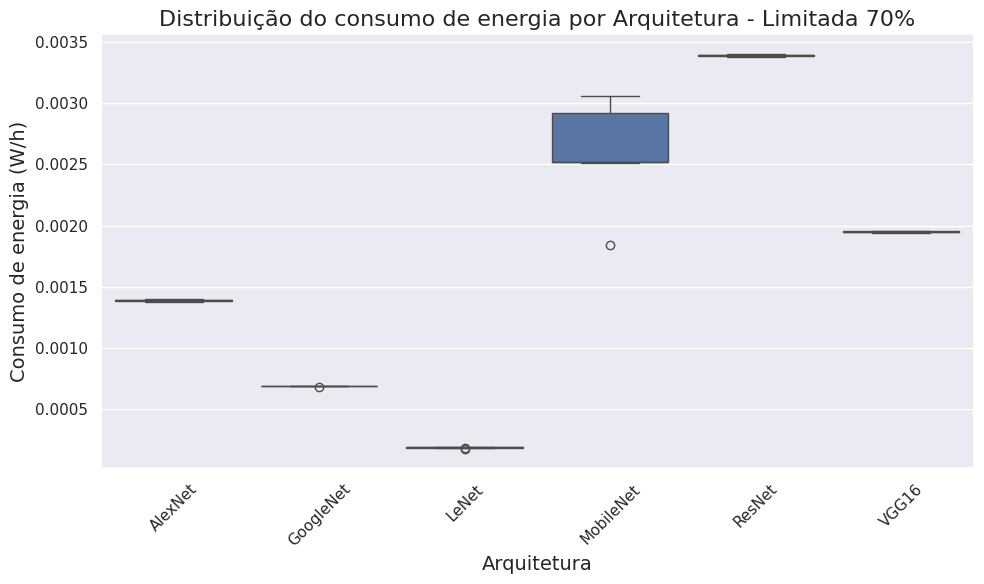

In [ ]:
# Visualização: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=dados_70, x='Arquitetura', y='Energia_kWh')
plt.title("Distribuição do consumo de energia por Arquitetura - Limitada 70%", fontsize=16)
plt.xlabel("Arquitetura", fontsize=14)
plt.ylabel("Consumo de energia (W/h)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Análise - 75%

### Duração

In [ ]:
# Obter arquiteturas
duracao_por_arquitetura = [dados_75[dados_75['Arquitetura'] == arq]['Duracao'].values for arq in arquiteturas]

# Teste de normalidade (Kolmogorov-Smirnov)
normalidade = {arq: kstest(valores, 'norm').pvalue for arq, valores in zip(arquiteturas, duracao_por_arquitetura)}
print("Resultados do teste de normalidade (Kolmogorov-Smirnov):\n")

for id, p_valor in normalidade.items():
    if p_valor > 0.05:
        print(f"A arquitetura {id} segue uma distribuição normal.")
    else:
        print(f"A arquitetura {id} NÃO segue uma distribuição normal.")

Resultados do teste de normalidade (Kolmogorov-Smirnov):

A arquitetura AlexNet NÃO segue uma distribuição normal.
A arquitetura GoogleNet NÃO segue uma distribuição normal.
A arquitetura LeNet NÃO segue uma distribuição normal.
A arquitetura MobileNet NÃO segue uma distribuição normal.
A arquitetura ResNet NÃO segue uma distribuição normal.
A arquitetura VGG16 NÃO segue uma distribuição normal.


In [ ]:
# Teste de Kruskal-Wallis
kruskal_result = kruskal(*duracao_por_arquitetura)
print("\nResultado do teste de Kruskal-Wallis:")
print(f"Estatística H = {kruskal_result.statistic:.2f} e p-valor = {kruskal_result.pvalue}.")


Resultado do teste de Kruskal-Wallis:
Estatística H = 56.79 e p-valor = 5.5951336643516835e-11.


In [ ]:
# Aplicar teste de Dunn
valores = dados_75['Duracao'].values
grupos = dados_75['Arquitetura'].values
dunn_result = dunn_posthoc_test(valores, grupos)

print("\nTeste de Dunn (correção Holm) - p-valores entre pares:")
dunn_result.style.map(colorir_celula)


Teste de Dunn (correção Holm) - p-valores entre pares:


,AlexNet,GoogleNet,LeNet,MobileNet,ResNet,VGG16
AlexNet,nan,0.795055,0.057372,0.002252,0.089920,0.305696
GoogleNet,0.795055,nan,0.400831,0.000004,0.001470,0.104907
LeNet,0.057372,0.400831,nan,0.000000,0.000004,0.002048
MobileNet,0.002252,0.000004,0.000000,nan,0.601246,0.064543
ResNet,0.089920,0.001470,0.000004,0.601246,nan,0.636044
VGG16,0.305696,0.104907,0.002048,0.064543,0.636044,nan


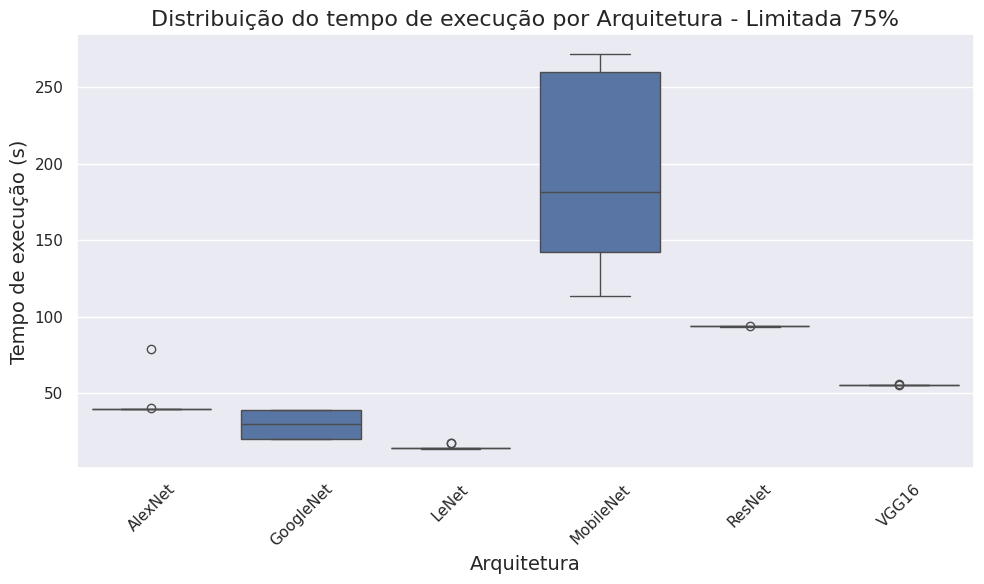

In [ ]:
# Visualização: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=dados_75, x='Arquitetura', y='Duracao')
plt.title("Distribuição do tempo de execução por Arquitetura - Limitada 75%", fontsize=16)
plt.xlabel("Arquitetura", fontsize=14)
plt.ylabel("Tempo de execução (s)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Consumo de energia

In [ ]:
# Obter arquiteturas
duracao_por_arquitetura = [dados_75[dados_75['Arquitetura'] == arq]['Energia_kWh'].values for arq in arquiteturas]

# Teste de normalidade (Kolmogorov-Smirnov)
normalidade = {arq: kstest(valores, 'norm').pvalue for arq, valores in zip(arquiteturas, duracao_por_arquitetura)}
print("Resultados do teste de normalidade (Kolmogorov-Smirnov):")
normalidade

for id, p_valor in normalidade.items():
    if p_valor > 0.05:
        print(f"A arquitetura {id} segue uma distribuição normal.")
    else:
        print(f"A arquitetura {id} NÃO segue uma distribuição normal.")

Resultados do teste de normalidade (Kolmogorov-Smirnov):
A arquitetura AlexNet NÃO segue uma distribuição normal.
A arquitetura GoogleNet NÃO segue uma distribuição normal.
A arquitetura LeNet NÃO segue uma distribuição normal.
A arquitetura MobileNet NÃO segue uma distribuição normal.
A arquitetura ResNet NÃO segue uma distribuição normal.
A arquitetura VGG16 NÃO segue uma distribuição normal.


In [ ]:
# Teste de Kruskal-Wallis
kruskal_result = kruskal(*duracao_por_arquitetura)
print("\nResultado do teste de Kruskal-Wallis:")
print(f"Estatística H = {kruskal_result.statistic:.2f} e p-valor = {kruskal_result.pvalue}.")


Resultado do teste de Kruskal-Wallis:
Estatística H = 56.79 e p-valor = 5.5951336643516835e-11.


In [ ]:
# Aplicar teste de Dunn
valores = dados_75['Energia_kWh'].values
grupos = dados_75['Arquitetura'].values
dunn_result = dunn_posthoc_test(valores, grupos)

print("\nTeste de Dunn (correção Holm) - p-valores entre pares:")
dunn_result.style.map(colorir_celula)


Teste de Dunn (correção Holm) - p-valores entre pares:


,AlexNet,GoogleNet,LeNet,MobileNet,ResNet,VGG16
AlexNet,nan,0.795055,0.057372,0.002252,0.089920,0.305696
GoogleNet,0.795055,nan,0.400831,0.000004,0.001470,0.104907
LeNet,0.057372,0.400831,nan,0.000000,0.000004,0.002048
MobileNet,0.002252,0.000004,0.000000,nan,0.601246,0.064543
ResNet,0.089920,0.001470,0.000004,0.601246,nan,0.636044
VGG16,0.305696,0.104907,0.002048,0.064543,0.636044,nan


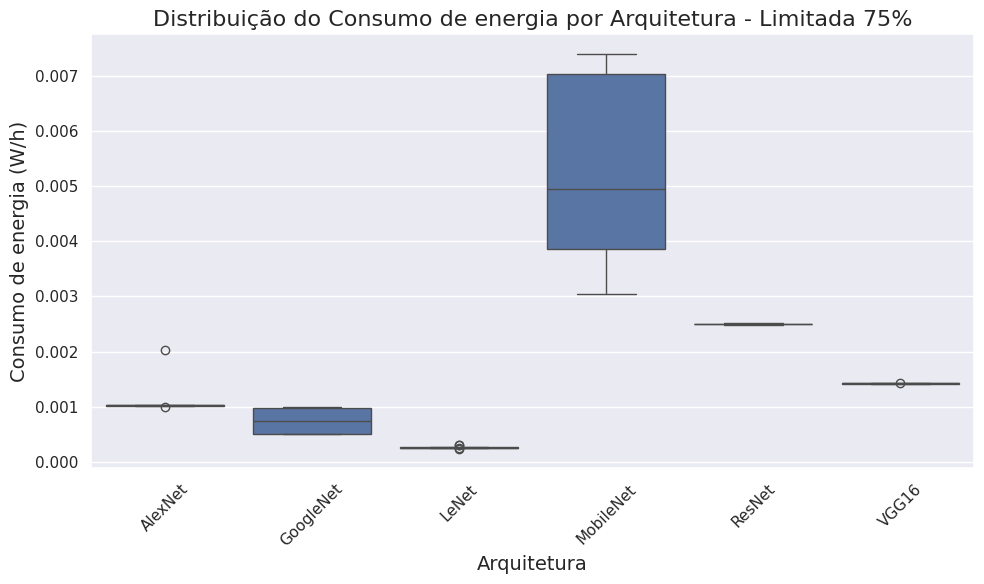

In [ ]:
# Visualização: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=dados_75, x='Arquitetura', y='Energia_kWh')
plt.title("Distribuição do Consumo de energia por Arquitetura - Limitada 75%", fontsize=16)
plt.xlabel("Arquitetura", fontsize=14)
plt.ylabel("Consumo de energia (W/h)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

## Análise - 80%

### Duração

In [ ]:
# Obter arquiteturas
duracao_por_arquitetura = [dados_80[dados_80['Arquitetura'] == arq]['Duracao'].values for arq in arquiteturas]

# Teste de normalidade (Kolmogorov-Smirnov)
normalidade = {arq: kstest(valores, 'norm').pvalue for arq, valores in zip(arquiteturas, duracao_por_arquitetura)}
print("Resultados do teste de normalidade (Kolmogorov-Smirnov):")

for id, p_valor in normalidade.items():
    if p_valor > 0.05:
        print(f"A arquitetura {id} segue uma distribuição normal.")
    else:
        print(f"A arquitetura {id} NÃO segue uma distribuição normal.")

Resultados do teste de normalidade (Kolmogorov-Smirnov):
A arquitetura AlexNet NÃO segue uma distribuição normal.
A arquitetura GoogleNet NÃO segue uma distribuição normal.
A arquitetura LeNet NÃO segue uma distribuição normal.
A arquitetura MobileNet NÃO segue uma distribuição normal.
A arquitetura ResNet NÃO segue uma distribuição normal.
A arquitetura VGG16 NÃO segue uma distribuição normal.


In [ ]:
# Teste de Kruskal-Wallis
kruskal_result = kruskal(*duracao_por_arquitetura)
print("\nResultado do teste de Kruskal-Wallis:")
print(f"Estatística H = {kruskal_result.statistic:.2f} e p-valor = {kruskal_result.pvalue}.")


Resultado do teste de Kruskal-Wallis:
Estatística H = 56.30 e p-valor = 7.034667460402105e-11.


In [ ]:
# Aplicar teste de Dunn
valores = dados_80['Duracao'].values
grupos = dados_80['Arquitetura'].values
dunn_result = dunn_posthoc_test(valores, grupos)

print("\nTeste de Dunn (correção Holm) - p-valores entre pares:")
dunn_result.style.map(colorir_celula)


Teste de Dunn (correção Holm) - p-valores entre pares:


,AlexNet,GoogleNet,LeNet,MobileNet,ResNet,VGG16
AlexNet,nan,0.654152,0.000866,0.089920,0.305696,0.087300
GoogleNet,0.654152,nan,0.097715,0.000883,0.089924,0.564293
LeNet,0.000866,0.097715,nan,0.000000,0.000008,0.500180
MobileNet,0.089920,0.000883,0.000000,nan,0.636044,0.000007
ResNet,0.305696,0.089924,0.000008,0.636044,nan,0.003054
VGG16,0.087300,0.564293,0.500180,0.000007,0.003054,nan


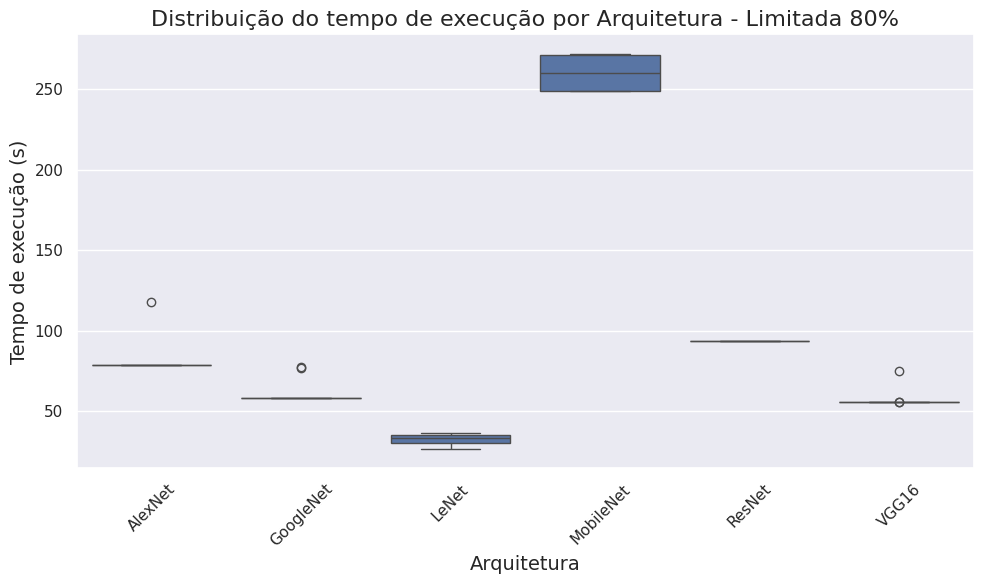

In [ ]:
# Visualização: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=dados_80, x='Arquitetura', y='Duracao')
plt.title("Distribuição do tempo de execução por Arquitetura - Limitada 80%", fontsize=16)
plt.xlabel("Arquitetura", fontsize=14)
plt.ylabel("Tempo de execução (s)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Consumo de energia

In [ ]:
# Obter arquiteturas
duracao_por_arquitetura = [dados_80[dados_80['Arquitetura'] == arq]['Energia_kWh'].values for arq in arquiteturas]

# Teste de normalidade (Kolmogorov-Smirnov)
normalidade = {arq: kstest(valores, 'norm').pvalue for arq, valores in zip(arquiteturas, duracao_por_arquitetura)}
print("Resultados do teste de normalidade (Kolmogorov-Smirnov):")
normalidade

for id, p_valor in normalidade.items():
    if p_valor > 0.05:
        print(f"A arquitetura {id} segue uma distribuição normal.")
    else:
        print(f"A arquitetura {id} NÃO segue uma distribuição normal.")

Resultados do teste de normalidade (Kolmogorov-Smirnov):
A arquitetura AlexNet NÃO segue uma distribuição normal.
A arquitetura GoogleNet NÃO segue uma distribuição normal.
A arquitetura LeNet NÃO segue uma distribuição normal.
A arquitetura MobileNet NÃO segue uma distribuição normal.
A arquitetura ResNet NÃO segue uma distribuição normal.
A arquitetura VGG16 NÃO segue uma distribuição normal.


In [ ]:
# Teste de Kruskal-Wallis
kruskal_result = kruskal(*duracao_por_arquitetura)
print("\nResultado do teste de Kruskal-Wallis:")
print(f"Estatística H = {kruskal_result.statistic:.2f} e p-valor = {kruskal_result.pvalue}.")


Resultado do teste de Kruskal-Wallis:
Estatística H = 56.30 e p-valor = 7.034667460402105e-11.


In [ ]:
# Aplicar teste de Dunn
valores = dados_80['Energia_kWh'].values
grupos = dados_80['Arquitetura'].values
dunn_result = dunn_posthoc_test(valores, grupos)

print("\nTeste de Dunn (correção Holm) - p-valores entre pares:")
dunn_result.style.map(colorir_celula)


Teste de Dunn (correção Holm) - p-valores entre pares:


,AlexNet,GoogleNet,LeNet,MobileNet,ResNet,VGG16
AlexNet,nan,0.654152,0.000866,0.089920,0.305696,0.087300
GoogleNet,0.654152,nan,0.097715,0.000883,0.089924,0.564293
LeNet,0.000866,0.097715,nan,0.000000,0.000008,0.500180
MobileNet,0.089920,0.000883,0.000000,nan,0.636044,0.000007
ResNet,0.305696,0.089924,0.000008,0.636044,nan,0.003054
VGG16,0.087300,0.564293,0.500180,0.000007,0.003054,nan


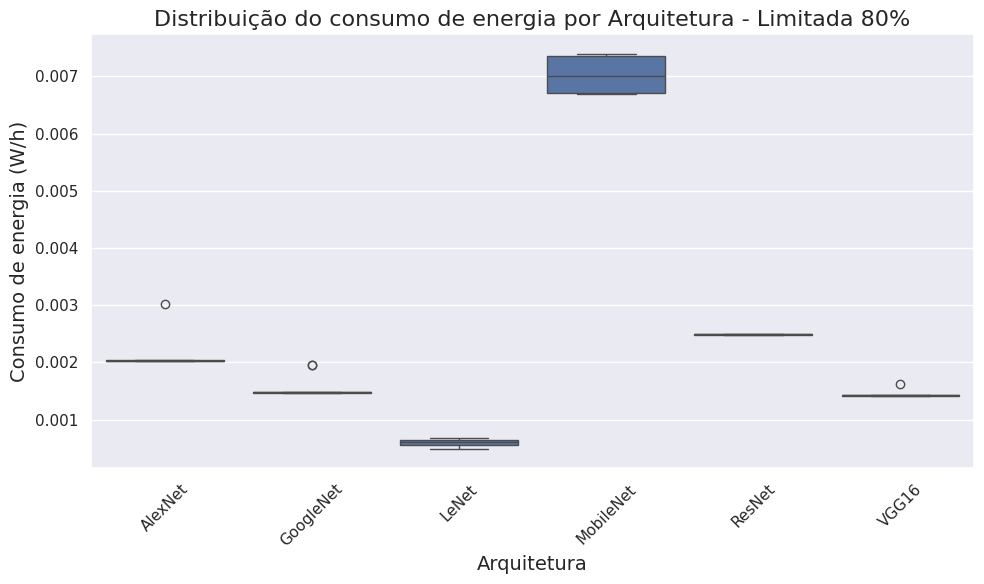

In [ ]:
# Visualização: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=dados_80, x='Arquitetura', y='Energia_kWh')
plt.title("Distribuição do consumo de energia por Arquitetura - Limitada 80%", fontsize=16)
plt.xlabel("Arquitetura", fontsize=14)
plt.ylabel("Consumo de energia (W/h)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Análise - 85%

### Duração

In [ ]:
# Obter arquiteturas
duracao_por_arquitetura = [dados_85[dados_85['Arquitetura'] == arq]['Duracao'].values for arq in arquiteturas]

# Teste de normalidade (Kolmogorov-Smirnov)
normalidade = {arq: kstest(valores, 'norm').pvalue for arq, valores in zip(arquiteturas, duracao_por_arquitetura)}
print("Resultados do teste de normalidade (Kolmogorov-Smirnov):")

for id, p_valor in normalidade.items():
    if p_valor > 0.05:
        print(f"A arquitetura {id} segue uma distribuição normal.")
    else:
        print(f"A arquitetura {id} NÃO segue uma distribuição normal.")

Resultados do teste de normalidade (Kolmogorov-Smirnov):
A arquitetura AlexNet NÃO segue uma distribuição normal.
A arquitetura GoogleNet NÃO segue uma distribuição normal.
A arquitetura LeNet NÃO segue uma distribuição normal.
A arquitetura MobileNet NÃO segue uma distribuição normal.
A arquitetura ResNet NÃO segue uma distribuição normal.
A arquitetura VGG16 NÃO segue uma distribuição normal.


In [ ]:
# Teste de Kruskal-Wallis
kruskal_result = kruskal(*duracao_por_arquitetura)
print("\nResultado do teste de Kruskal-Wallis:")
print(f"Estatística H = {kruskal_result.statistic:.2f} e p-valor = {kruskal_result.pvalue}.")


Resultado do teste de Kruskal-Wallis:
Estatística H = 54.31 e p-valor = 1.8119202689120048e-10.


In [ ]:
# Aplicar teste de Dunn
valores = dados_85['Duracao'].values
grupos = dados_85['Arquitetura'].values
dunn_result = dunn_posthoc_test(valores, grupos)

print("\nTeste de Dunn (correção Holm) - p-valores entre pares:")
dunn_result.style.map(colorir_celula)


Teste de Dunn (correção Holm) - p-valores entre pares:


,AlexNet,GoogleNet,LeNet,MobileNet,ResNet,VGG16
AlexNet,nan,0.839757,0.013102,0.354829,0.101165,0.000018
GoogleNet,0.839757,nan,0.128640,0.124961,0.419495,0.000605
LeNet,0.013102,0.128640,nan,0.000023,0.497394,0.415740
MobileNet,0.354829,0.124961,0.000023,nan,0.000502,0.000000
ResNet,0.101165,0.419495,0.497394,0.000502,nan,0.127112
VGG16,0.000018,0.000605,0.415740,0.000000,0.127112,nan


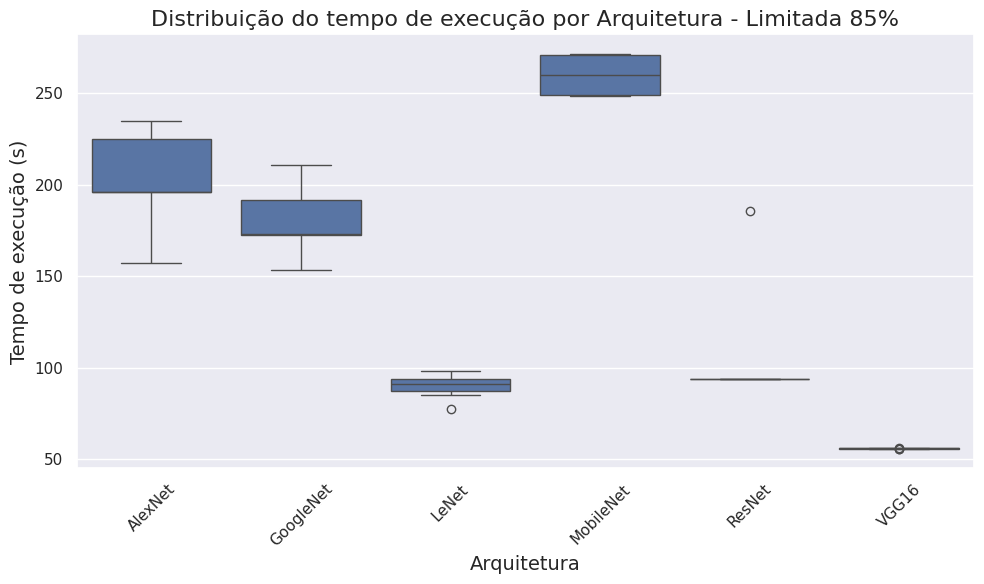

In [ ]:
# Visualização: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=dados_85, x='Arquitetura', y='Duracao')
plt.title("Distribuição do tempo de execução por Arquitetura - Limitada 85%", fontsize=16)
plt.xlabel("Arquitetura", fontsize=14)
plt.ylabel("Tempo de execução (s)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Consumo energia

In [ ]:
# Obter arquiteturas
duracao_por_arquitetura = [dados_85[dados_85['Arquitetura'] == arq]['Energia_kWh'].values for arq in arquiteturas]

# Teste de normalidade (Kolmogorov-Smirnov)
normalidade = {arq: kstest(valores, 'norm').pvalue for arq, valores in zip(arquiteturas, duracao_por_arquitetura)}
print("Resultados do teste de normalidade (Kolmogorov-Smirnov):")
normalidade

for id, p_valor in normalidade.items():
    if p_valor > 0.05:
        print(f"A arquitetura {id} segue uma distribuição normal.")
    else:
        print(f"A arquitetura {id} NÃO segue uma distribuição normal.")

Resultados do teste de normalidade (Kolmogorov-Smirnov):
A arquitetura AlexNet NÃO segue uma distribuição normal.
A arquitetura GoogleNet NÃO segue uma distribuição normal.
A arquitetura LeNet NÃO segue uma distribuição normal.
A arquitetura MobileNet NÃO segue uma distribuição normal.
A arquitetura ResNet NÃO segue uma distribuição normal.
A arquitetura VGG16 NÃO segue uma distribuição normal.


In [ ]:
# Teste de Kruskal-Wallis
kruskal_result = kruskal(*duracao_por_arquitetura)
print("\nResultado do teste de Kruskal-Wallis:")
print(f"Estatística H = {kruskal_result.statistic:.2f} e p-valor = {kruskal_result.pvalue}.")


Resultado do teste de Kruskal-Wallis:
Estatística H = 55.10 e p-valor = 1.243613256968946e-10.


In [ ]:
# Aplicar teste de Dunn
valores = dados_85['Energia_kWh'].values
grupos = dados_85['Arquitetura'].values
dunn_result = dunn_posthoc_test(valores, grupos)

print("\nTeste de Dunn (correção Holm) - p-valores entre pares:")
dunn_result.style.map(colorir_celula)


Teste de Dunn (correção Holm) - p-valores entre pares:


,AlexNet,GoogleNet,LeNet,MobileNet,ResNet,VGG16
AlexNet,nan,0.405274,0.002504,0.591381,0.182867,0.000028
GoogleNet,0.405274,nan,0.041944,0.116568,0.548991,0.001130
LeNet,0.002504,0.041944,nan,0.000002,0.536500,0.564293
MobileNet,0.591381,0.116568,0.000002,nan,0.002141,0.000000
ResNet,0.182867,0.548991,0.536500,0.002141,nan,0.080531
VGG16,0.000028,0.001130,0.564293,0.000000,0.080531,nan


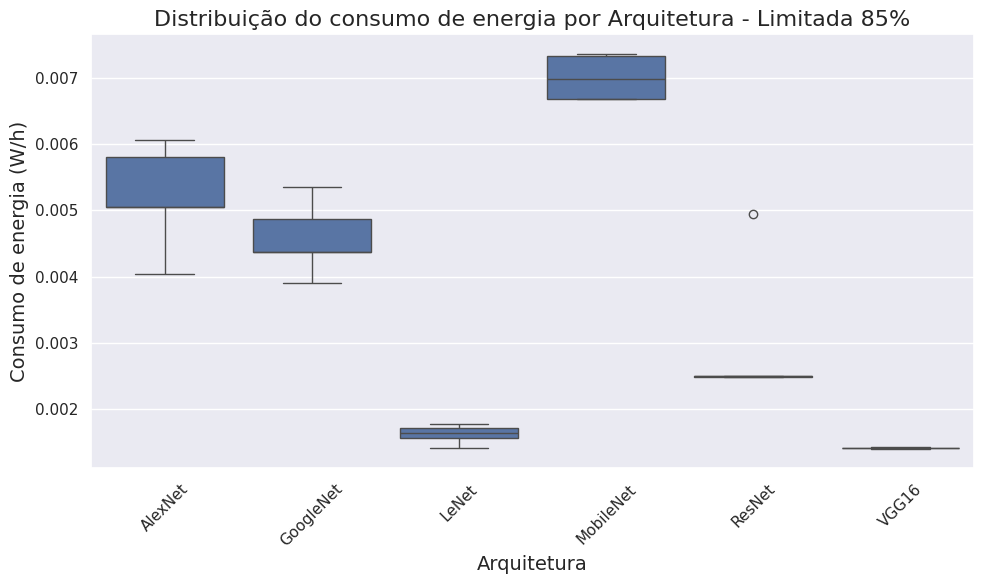

In [ ]:
# Visualização: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=dados_85, x='Arquitetura', y='Energia_kWh')
plt.title("Distribuição do consumo de energia por Arquitetura - Limitada 85%", fontsize=16)
plt.xlabel("Arquitetura", fontsize=14)
plt.ylabel("Consumo de energia (W/h)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Análise - 90%

### Duração

In [ ]:
# Obter arquiteturas
duracao_por_arquitetura = [dados_90[dados_90['Arquitetura'] == arq]['Duracao'].values for arq in arquiteturas]

# Teste de normalidade (Kolmogorov-Smirnov)
normalidade = {arq: kstest(valores, 'norm').pvalue for arq, valores in zip(arquiteturas, duracao_por_arquitetura)}
print("Resultados do teste de normalidade (Kolmogorov-Smirnov):")

for id, p_valor in normalidade.items():
    if p_valor > 0.05:
        print(f"A arquitetura {id} segue uma distribuição normal.")
    else:
        print(f"A arquitetura {id} NÃO segue uma distribuição normal.")

Resultados do teste de normalidade (Kolmogorov-Smirnov):
A arquitetura AlexNet NÃO segue uma distribuição normal.
A arquitetura GoogleNet NÃO segue uma distribuição normal.
A arquitetura LeNet NÃO segue uma distribuição normal.
A arquitetura MobileNet NÃO segue uma distribuição normal.
A arquitetura ResNet NÃO segue uma distribuição normal.
A arquitetura VGG16 NÃO segue uma distribuição normal.


In [ ]:
# Teste de Kruskal-Wallis
kruskal_result = kruskal(*duracao_por_arquitetura)
print("\nResultado do teste de Kruskal-Wallis:")
print(f"Estatística H = {kruskal_result.statistic:.2f} e p-valor = {kruskal_result.pvalue}.")


Resultado do teste de Kruskal-Wallis:
Estatística H = 52.36 e p-valor = 4.545567769147793e-10.


In [ ]:
# Aplicar teste de Dunn
valores = dados_90['Duracao'].values
grupos = dados_90['Arquitetura'].values
dunn_result = dunn_posthoc_test(valores, grupos)

print("\nTeste de Dunn (correção Holm) - p-valores entre pares:")
dunn_result.style.map(colorir_celula)


Teste de Dunn (correção Holm) - p-valores entre pares:


,AlexNet,GoogleNet,LeNet,MobileNet,ResNet,VGG16
AlexNet,nan,0.642756,0.000086,0.012530,0.547325,0.309813
GoogleNet,0.642756,nan,0.000000,0.000095,1.000000,0.012888
LeNet,0.000086,0.000000,nan,0.801662,0.000005,0.083560
MobileNet,0.012530,0.000095,0.801662,nan,0.001419,1.000000
ResNet,0.547325,1.000000,0.000005,0.001419,nan,0.075854
VGG16,0.309813,0.012888,0.083560,1.000000,0.075854,nan


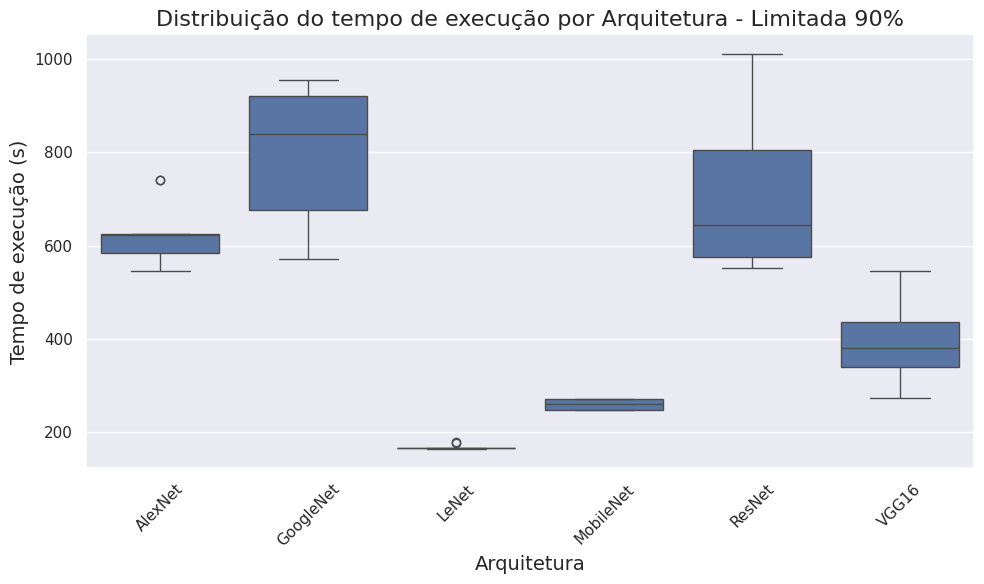

In [ ]:
# Visualização: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=dados_90, x='Arquitetura', y='Duracao')
plt.title("Distribuição do tempo de execução por Arquitetura - Limitada 90%", fontsize=16)
plt.xlabel("Arquitetura", fontsize=14)
plt.ylabel("Tempo de execução (s)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Consumo de energia

In [ ]:
# Obter arquiteturas
duracao_por_arquitetura = [dados_90[dados_90['Arquitetura'] == arq]['Energia_kWh'].values for arq in arquiteturas]

# Teste de normalidade (Kolmogorov-Smirnov)
normalidade = {arq: kstest(valores, 'norm').pvalue for arq, valores in zip(arquiteturas, duracao_por_arquitetura)}
print("Resultados do teste de normalidade (Kolmogorov-Smirnov):")
normalidade

for id, p_valor in normalidade.items():
    if p_valor > 0.05:
        print(f"A arquitetura {id} segue uma distribuição normal.")
    else:
        print(f"A arquitetura {id} NÃO segue uma distribuição normal.")

Resultados do teste de normalidade (Kolmogorov-Smirnov):
A arquitetura AlexNet NÃO segue uma distribuição normal.
A arquitetura GoogleNet NÃO segue uma distribuição normal.
A arquitetura LeNet NÃO segue uma distribuição normal.
A arquitetura MobileNet NÃO segue uma distribuição normal.
A arquitetura ResNet NÃO segue uma distribuição normal.
A arquitetura VGG16 NÃO segue uma distribuição normal.


In [ ]:
# Teste de Kruskal-Wallis
kruskal_result = kruskal(*duracao_por_arquitetura)
print("\nResultado do teste de Kruskal-Wallis:")
print(f"Estatística H = {kruskal_result.statistic:.2f} e p-valor = {kruskal_result.pvalue}.")


Resultado do teste de Kruskal-Wallis:
Estatística H = 51.54 e p-valor = 6.691951568144144e-10.


In [ ]:
# Aplicar teste de Dunn
valores = dados_90['Energia_kWh'].values
grupos = dados_90['Arquitetura'].values
dunn_result = dunn_posthoc_test(valores, grupos)

print("\nTeste de Dunn (correção Holm) - p-valores entre pares:")
dunn_result.style.map(colorir_celula)


Teste de Dunn (correção Holm) - p-valores entre pares:


,AlexNet,GoogleNet,LeNet,MobileNet,ResNet,VGG16
AlexNet,nan,0.935344,0.000059,0.011981,1.000000,0.221328
GoogleNet,0.935344,nan,0.000000,0.000256,0.682013,0.017506
LeNet,0.000059,0.000000,nan,0.894116,0.000003,0.087744
MobileNet,0.011981,0.000256,0.894116,nan,0.001347,0.996739
ResNet,1.000000,0.682013,0.000003,0.001347,nan,0.057372
VGG16,0.221328,0.017506,0.087744,0.996739,0.057372,nan


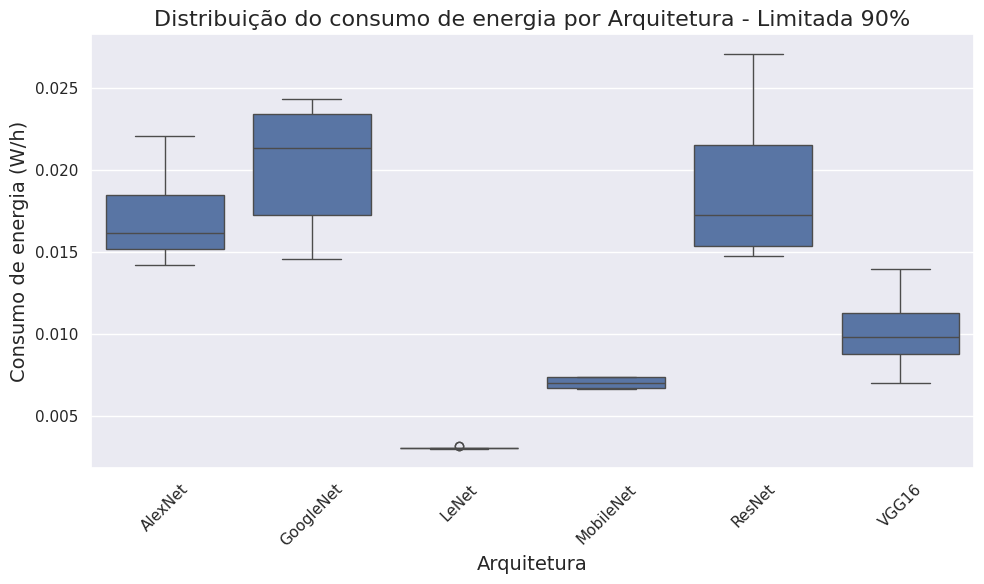

In [ ]:
# Visualização: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=dados_90, x='Arquitetura', y='Energia_kWh')
plt.title("Distribuição do consumo de energia por Arquitetura - Limitada 90%", fontsize=16)
plt.xlabel("Arquitetura", fontsize=14)
plt.ylabel("Consumo de energia (W/h)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Análise - 95%

### Duração

In [ ]:
# Obter arquiteturas
duracao_por_arquitetura = [dados_95[dados_95['Arquitetura'] == arq]['Duracao'].values for arq in arquiteturas]

# Teste de normalidade (Kolmogorov-Smirnov)
normalidade = {arq: kstest(valores, 'norm').pvalue for arq, valores in zip(arquiteturas, duracao_por_arquitetura)}
print("Resultados do teste de normalidade (Kolmogorov-Smirnov):")

for id, p_valor in normalidade.items():
    if p_valor > 0.05:
        print(f"A arquitetura {id} segue uma distribuição normal.")
    else:
        print(f"A arquitetura {id} NÃO segue uma distribuição normal.")

Resultados do teste de normalidade (Kolmogorov-Smirnov):
A arquitetura AlexNet NÃO segue uma distribuição normal.
A arquitetura GoogleNet NÃO segue uma distribuição normal.
A arquitetura LeNet NÃO segue uma distribuição normal.
A arquitetura MobileNet NÃO segue uma distribuição normal.
A arquitetura ResNet NÃO segue uma distribuição normal.
A arquitetura VGG16 NÃO segue uma distribuição normal.


In [ ]:
# Teste de Kruskal-Wallis
kruskal_result = kruskal(*duracao_por_arquitetura)
print("\nResultado do teste de Kruskal-Wallis:")
print(f"Estatística H = {kruskal_result.statistic:.2f} e p-valor = {kruskal_result.pvalue}.")


Resultado do teste de Kruskal-Wallis:
Estatística H = 54.02 e p-valor = 2.0783390877704747e-10.


In [ ]:
# Aplicar teste de Dunn
valores = dados_95['Duracao'].values
grupos = dados_95['Arquitetura'].values
dunn_result = dunn_posthoc_test(valores, grupos)

print("\nTeste de Dunn (correção Holm) - p-valores entre pares:")
dunn_result.style.map(colorir_celula)


Teste de Dunn (correção Holm) - p-valores entre pares:


,AlexNet,GoogleNet,LeNet,MobileNet,ResNet,VGG16
AlexNet,nan,0.150294,0.000000,0.000044,0.663326,0.018627
GoogleNet,0.150294,nan,0.002492,0.112560,0.355123,0.767890
LeNet,0.000000,0.002492,nan,0.601246,0.000001,0.043653
MobileNet,0.000044,0.112560,0.601246,nan,0.000303,0.497720
ResNet,0.663326,0.355123,0.000001,0.000303,nan,0.059611
VGG16,0.018627,0.767890,0.043653,0.497720,0.059611,nan


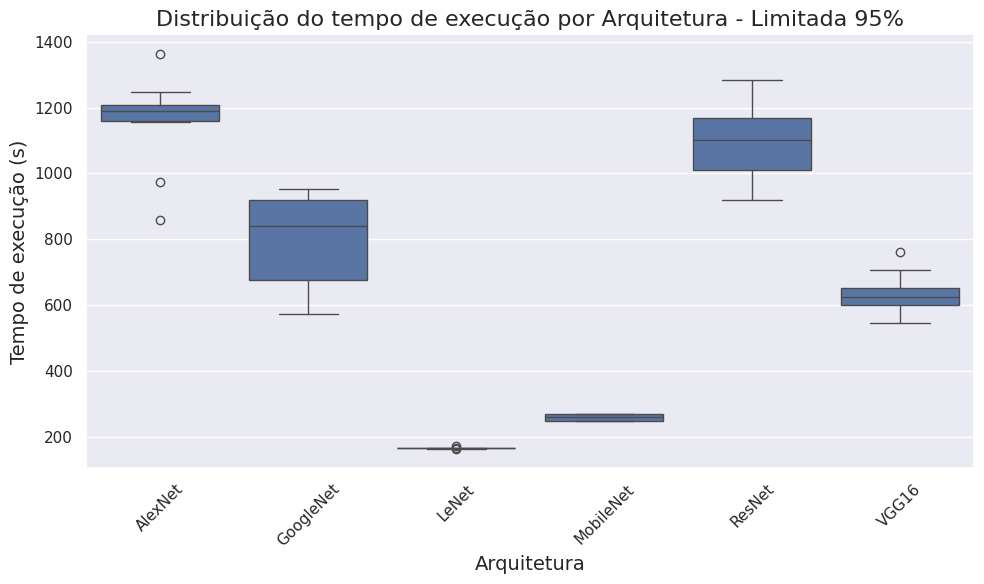

In [ ]:
# Visualização: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=dados_95, x='Arquitetura', y='Duracao')
plt.title("Distribuição do tempo de execução por Arquitetura - Limitada 95%", fontsize=16)
plt.xlabel("Arquitetura", fontsize=14)
plt.ylabel("Tempo de execução (s)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Consumo de energia

In [ ]:
# Obter arquiteturas
duracao_por_arquitetura = [dados_95[dados_95['Arquitetura'] == arq]['Energia_kWh'].values for arq in arquiteturas]

# Teste de normalidade (Kolmogorov-Smirnov)
normalidade = {arq: kstest(valores, 'norm').pvalue for arq, valores in zip(arquiteturas, duracao_por_arquitetura)}
print("Resultados do teste de normalidade (Kolmogorov-Smirnov):")
normalidade

for id, p_valor in normalidade.items():
    if p_valor > 0.05:
        print(f"A arquitetura {id} segue uma distribuição normal.")
    else:
        print(f"A arquitetura {id} NÃO segue uma distribuição normal.")

Resultados do teste de normalidade (Kolmogorov-Smirnov):
A arquitetura AlexNet NÃO segue uma distribuição normal.
A arquitetura GoogleNet NÃO segue uma distribuição normal.
A arquitetura LeNet NÃO segue uma distribuição normal.
A arquitetura MobileNet NÃO segue uma distribuição normal.
A arquitetura ResNet NÃO segue uma distribuição normal.
A arquitetura VGG16 NÃO segue uma distribuição normal.


In [ ]:
# Teste de Kruskal-Wallis
kruskal_result = kruskal(*duracao_por_arquitetura)
print("\nResultado do teste de Kruskal-Wallis:")
print(f"Estatística H = {kruskal_result.statistic:.2f} e p-valor = {kruskal_result.pvalue}.")


Resultado do teste de Kruskal-Wallis:
Estatística H = 54.32 e p-valor = 1.8046232459421376e-10.


In [ ]:
# Aplicar teste de Dunn
valores = dados_95['Energia_kWh'].values
grupos = dados_95['Arquitetura'].values
dunn_result = dunn_posthoc_test(valores, grupos)

print("\nTeste de Dunn (correção Holm) - p-valores entre pares:")
dunn_result.style.map(colorir_celula)


Teste de Dunn (correção Holm) - p-valores entre pares:


,AlexNet,GoogleNet,LeNet,MobileNet,ResNet,VGG16
AlexNet,nan,0.155346,0.000000,0.000059,0.797894,0.023092
GoogleNet,0.155346,nan,0.003043,0.129353,0.243181,0.825075
LeNet,0.000000,0.003043,nan,0.601246,0.000000,0.043653
MobileNet,0.000059,0.129353,0.601246,nan,0.000181,0.497720
ResNet,0.797894,0.243181,0.000000,0.000181,nan,0.042010
VGG16,0.023092,0.825075,0.043653,0.497720,0.042010,nan


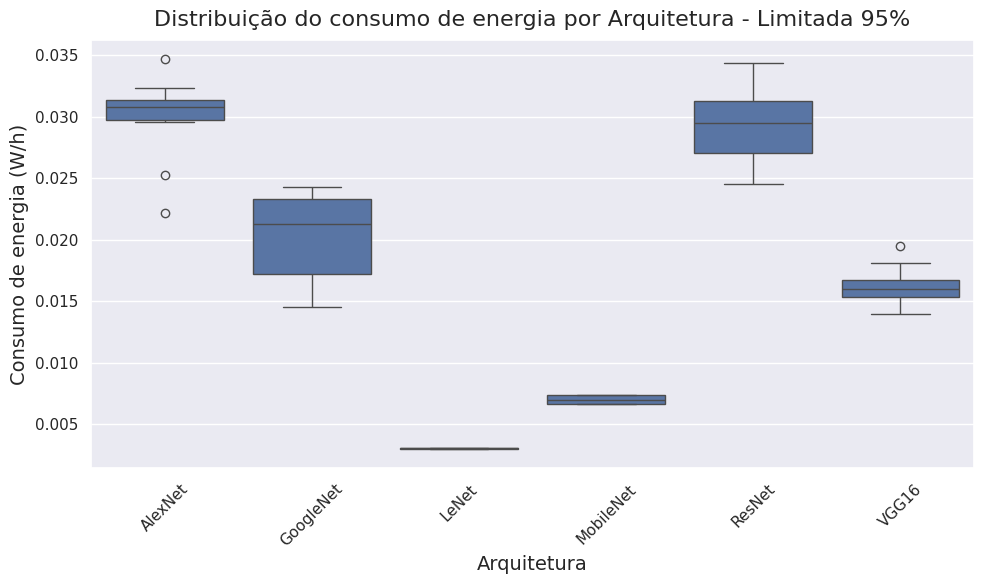

In [ ]:
# Visualização: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=dados_95, x='Arquitetura', y='Energia_kWh')
plt.title("Distribuição do consumo de energia por Arquitetura - Limitada 95%", fontsize=16, pad=10)
plt.xlabel("Arquitetura", fontsize=14)
plt.ylabel("Consumo de energia (W/h)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Visualizações

In [ ]:
#Gráficos
dados.head(2)

,Arquitetura,Limite,Execucao,Duracao,Energia_kWh,Emissao_kgCO2,Acuracia,Eficiencia_Energia,Eficiencia_Emissao
0,AlexNet,70,1,39.166152,0.001375,0.000135,0.762417,554.590133,5639.058582
1,AlexNet,70,2,39.142986,0.001389,0.000137,0.762833,549.141987,5583.661965


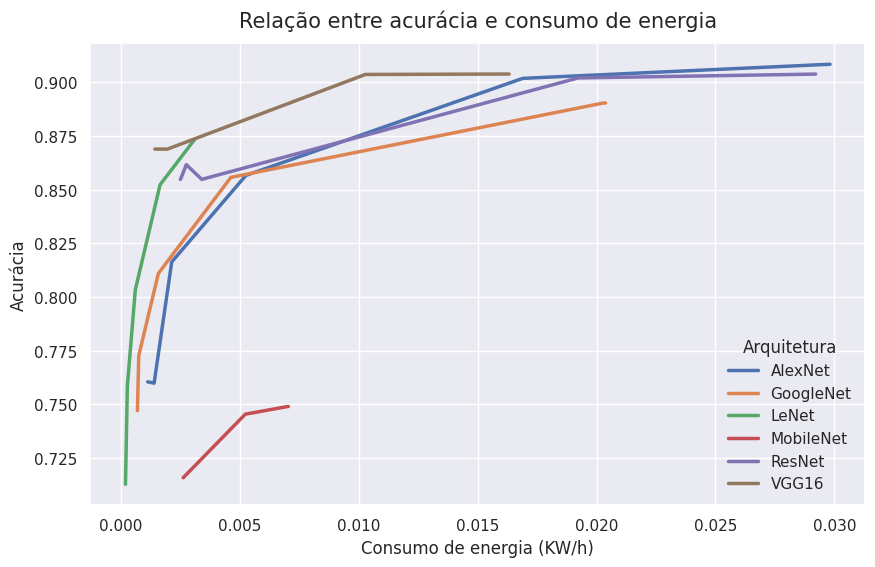

In [ ]:
#Gráfico de linhas de energia consumida e acurácia
plt.figure(figsize=(10, 6))
sns.lineplot(y='Acuracia', x='Energia_kWh', data=dados_agrupados, hue='Arquitetura', linewidth=2.5)
plt.title('Relação entre acurácia e consumo de energia', fontsize=15, pad=12)
plt.xlabel('Consumo de energia (KW/h)')
plt.ylabel('Acurácia')
plt.show()

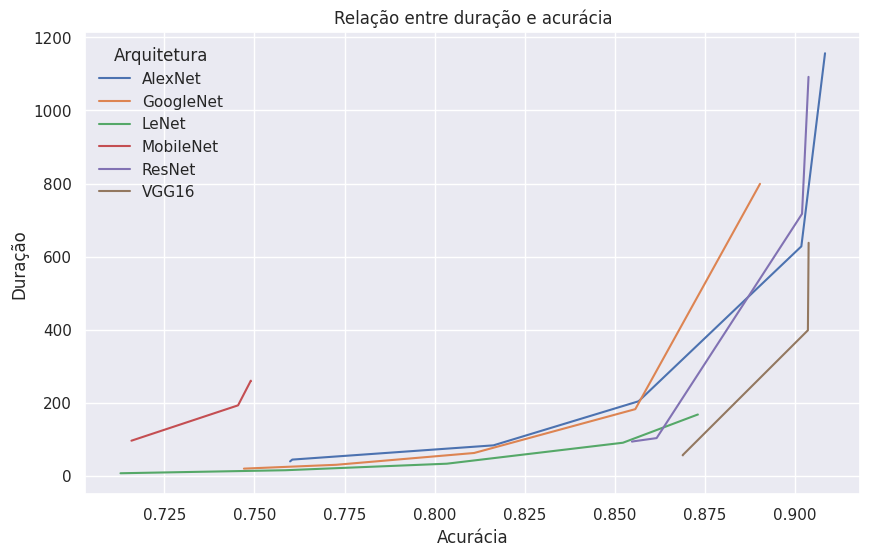

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Acuracia', y='Duracao', data=dados_agrupados, hue='Arquitetura')
plt.title('Relação entre duração e acurácia')
plt.xlabel('Acurácia')
plt.ylabel('Duração')
plt.show()

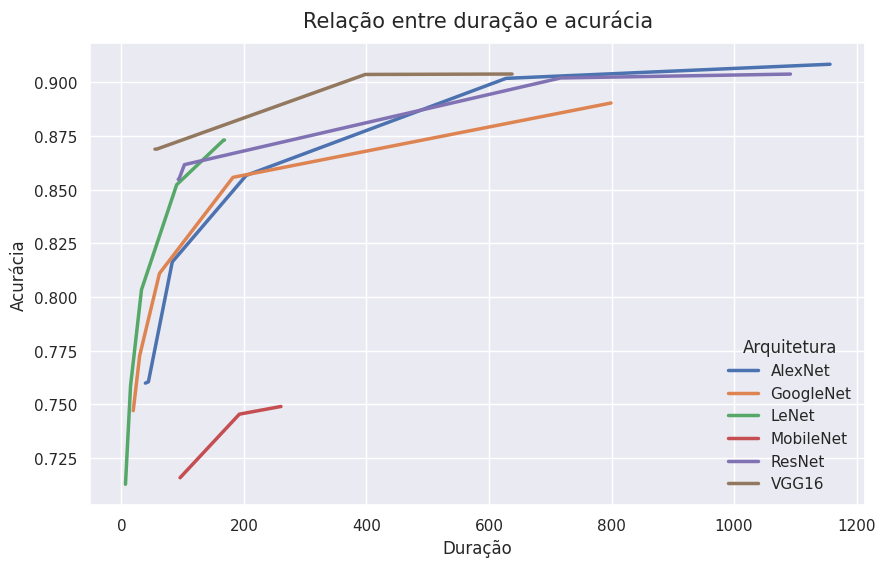

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(y='Acuracia', x='Duracao', data=dados_agrupados, hue='Arquitetura', linewidth=2.5)
plt.title('Relação entre duração e acurácia', fontsize=15, pad=12)
plt.ylabel('Acurácia', fontsize=12)
plt.xlabel('Duração', fontsize=12)
plt.show()

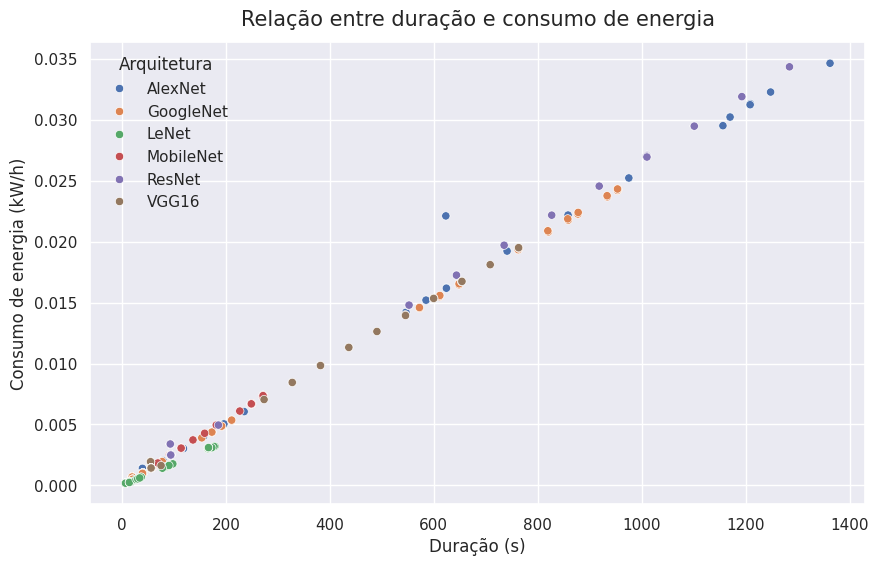

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dados, x='Duracao', y='Energia_kWh', hue='Arquitetura')
plt.title('Relação entre duração e consumo de energia', fontsize=15, pad=12)
plt.xlabel('Duração (s)', fontsize=12)
plt.ylabel('Consumo de energia (kW/h)', fontsize=12)
plt.show()

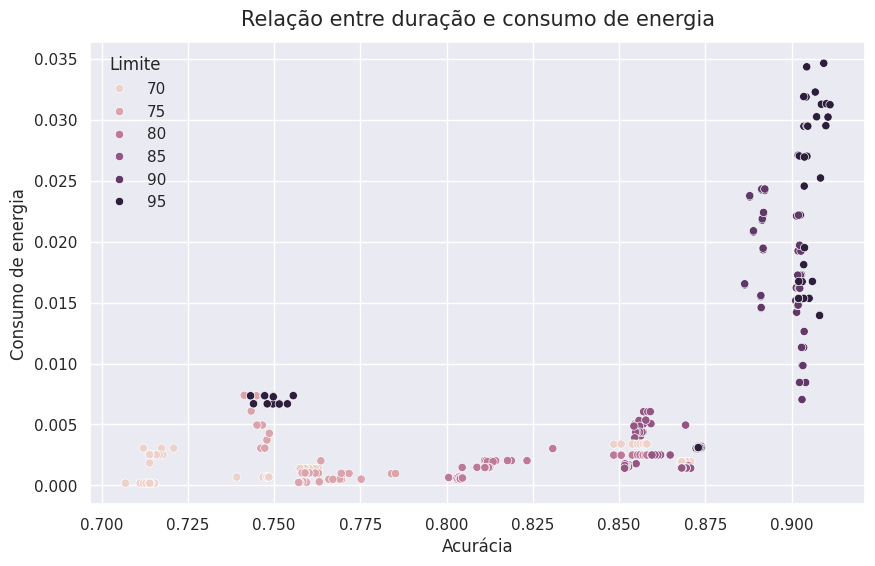

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dados, x='Acuracia', y='Energia_kWh', hue='Limite')
plt.title('Relação entre duração e consumo de energia', fontsize=15, pad=12)
plt.xlabel('Acurácia', fontsize=12)
plt.ylabel('Consumo de energia', fontsize=12)
plt.show()

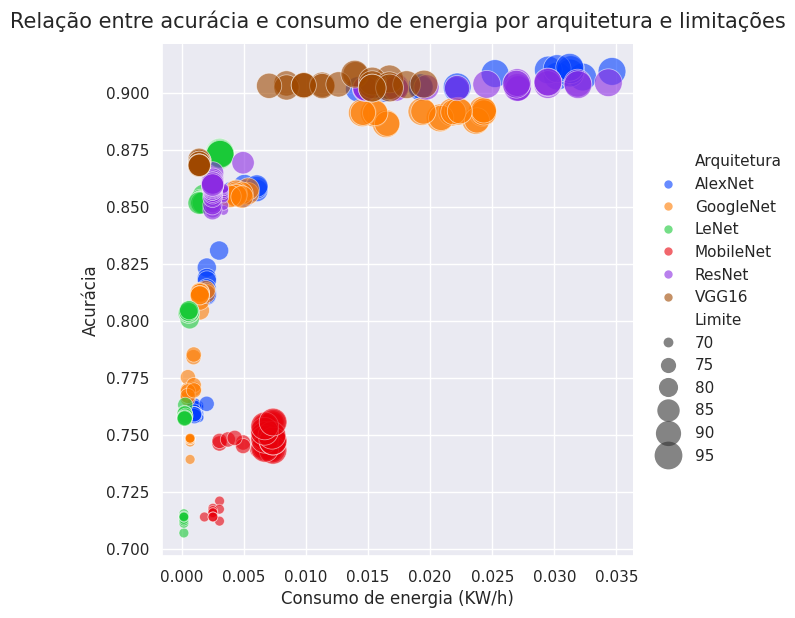

In [ ]:
# plt.figure(figsize=(10, 12))
sns.relplot(data=dados, y='Acuracia', x='Energia_kWh', hue='Arquitetura', size='Limite',
            sizes=(50, 400), alpha=.6, height=6, palette="bright")
plt.title('Relação entre acurácia e consumo de energia por arquitetura e limitações', fontsize=15, pad=12)
plt.ylabel('Acurácia', fontsize=12)
plt.xlabel('Consumo de energia (KW/h)', fontsize=12)
# plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 11.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 43.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 15.0% of the points cannot be place

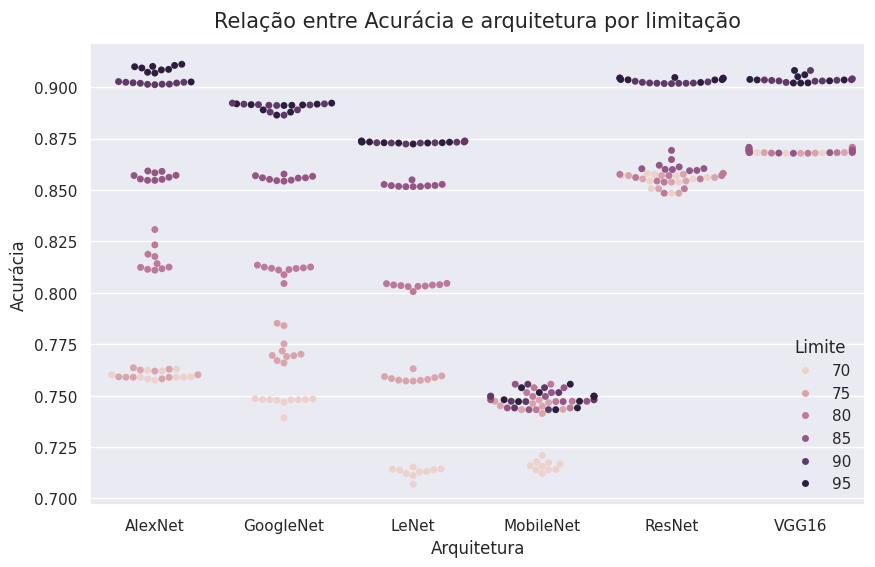

In [ ]:
plt.figure(figsize=(10, 6))
sns.swarmplot(data=dados, x='Arquitetura', y='Acuracia', hue='Limite')
plt.title('Relação entre Acurácia e arquitetura por limitação', fontsize=15, pad=12)
plt.ylabel('Acurácia', fontsize=12)
plt.xlabel('Arquitetura', fontsize=12)
plt.show()

In [ ]:
import matplotlib.ticker as mticker

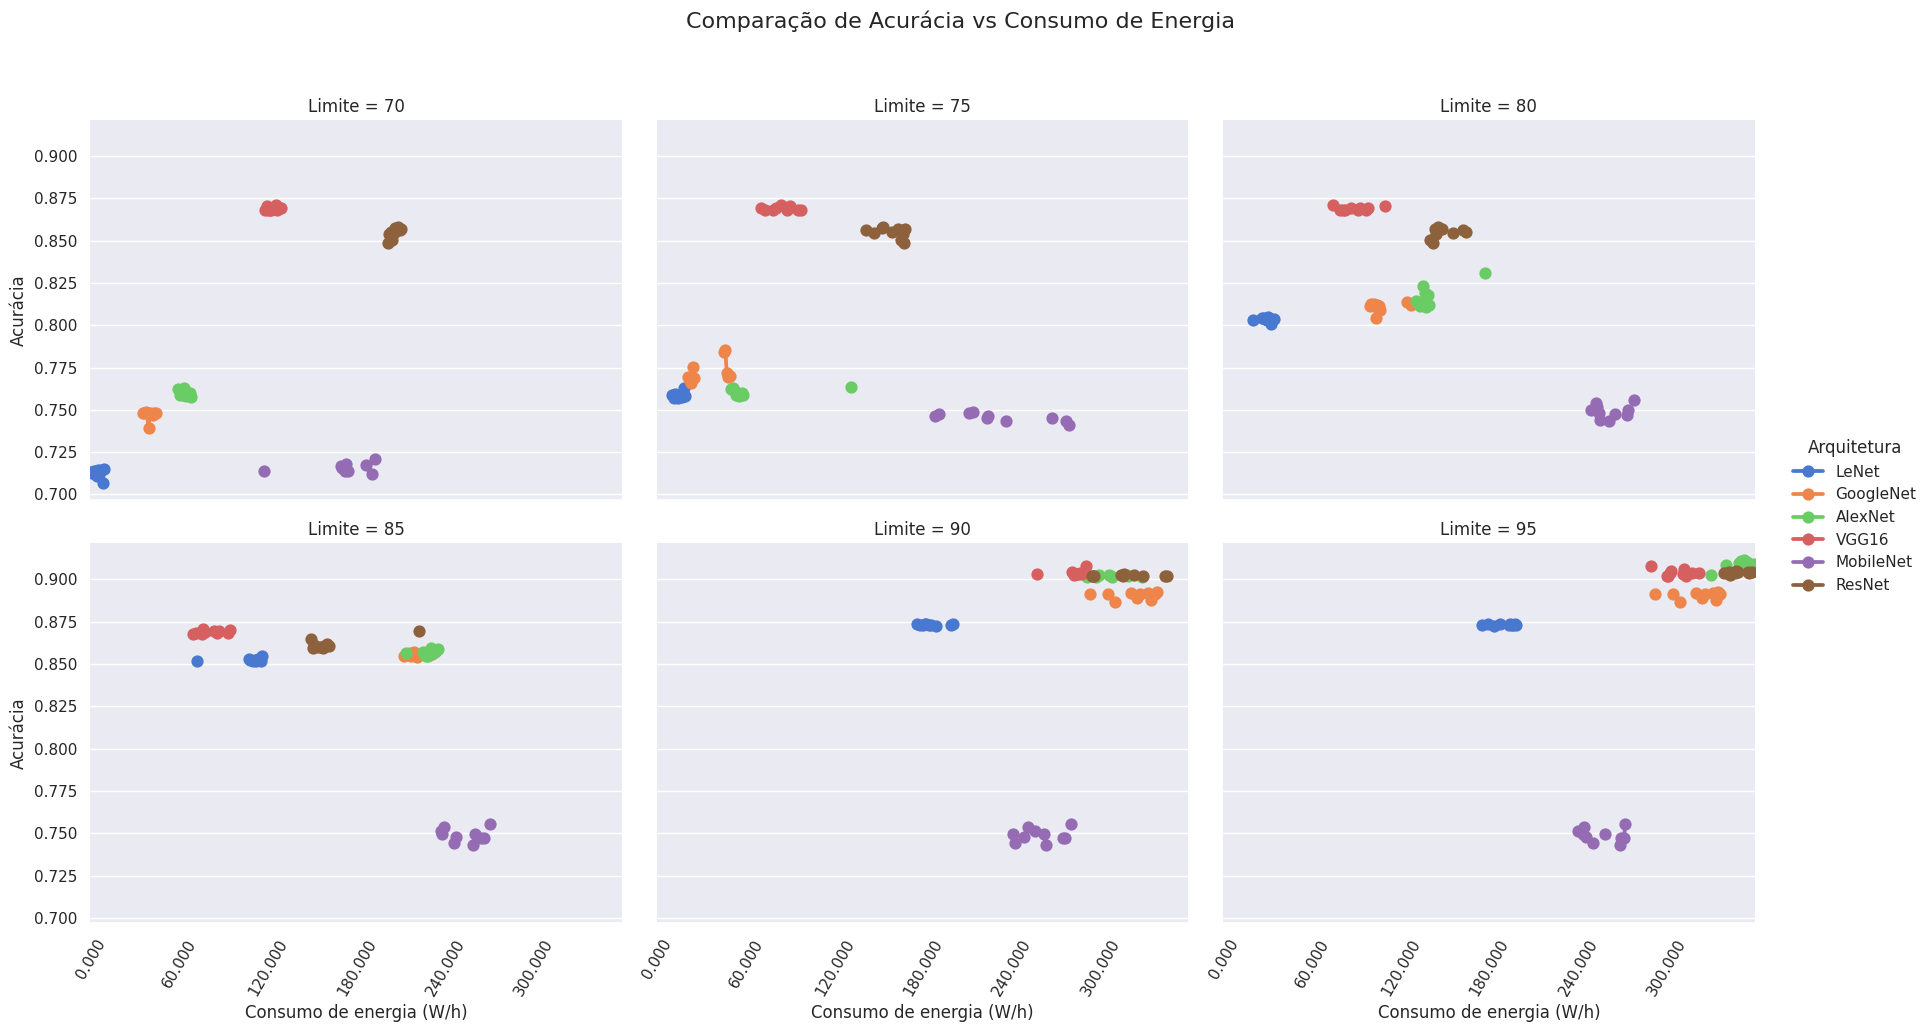

In [ ]:
g = sns.catplot(data=dados, y='Acuracia', x='Energia_kWh', hue='Arquitetura', col='Limite',
                capsize=.2, errorbar="se", kind="point", height=5, aspect=1.2, col_wrap=3, palette="muted")

for ax in g.axes.flat:
    ax.tick_params(axis='x', labelrotation=60)
    ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=7))
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.3f}'))

g.fig.suptitle("Comparação de Acurácia vs Consumo de Energia", fontsize=16, y=1.03)

g.despine(left=True)
g.set_axis_labels(x_var="Consumo de energia (W/h)", y_var="Acurácia")
g.legend.set_title("Arquitetura")

g.tight_layout()
plt.show()

### Visualizações por limitação

In [ ]:
# Agrupar por Arquitetura e Limitação (%) e calcular a média
dados_agrupados_70 = dados_70.groupby(['Arquitetura', 'Limite'])[['Duracao', 'Energia_kWh', 'Emissao_kgCO2', 'Acuracia', 'Eficiencia_Energia', 'Eficiencia_Emissao']].mean()
dados_agrupados_75 = dados_75.groupby(['Arquitetura', 'Limite'])[['Duracao', 'Energia_kWh', 'Emissao_kgCO2', 'Acuracia', 'Eficiencia_Energia', 'Eficiencia_Emissao']].mean()
dados_agrupados_80 = dados_80.groupby(['Arquitetura', 'Limite'])[['Duracao', 'Energia_kWh', 'Emissao_kgCO2', 'Acuracia', 'Eficiencia_Energia', 'Eficiencia_Emissao']].mean()
dados_agrupados_85 = dados_85.groupby(['Arquitetura', 'Limite'])[['Duracao', 'Energia_kWh', 'Emissao_kgCO2', 'Acuracia', 'Eficiencia_Energia', 'Eficiencia_Emissao']].mean()
dados_agrupados_90 = dados_90.groupby(['Arquitetura', 'Limite'])[['Duracao', 'Energia_kWh', 'Emissao_kgCO2', 'Acuracia', 'Eficiencia_Energia', 'Eficiencia_Emissao']].mean()
dados_agrupados_95 = dados_95.groupby(['Arquitetura', 'Limite'])[['Duracao', 'Energia_kWh', 'Emissao_kgCO2', 'Acuracia', 'Eficiencia_Energia', 'Eficiencia_Emissao']].mean()

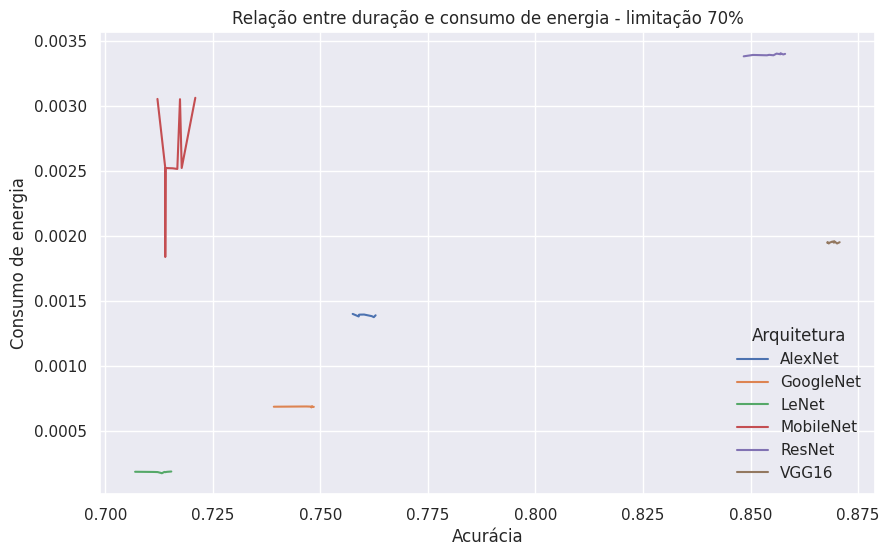

In [ ]:
#Gráfico de linhas de energia consumida e acurácia
plt.figure(figsize=(10, 6))
sns.lineplot(x='Acuracia', y='Energia_kWh', data=dados_70, hue='Arquitetura')
plt.title('Relação entre duração e consumo de energia - limitação 70%')
plt.xlabel('Acurácia')
plt.ylabel('Consumo de energia')
plt.show()

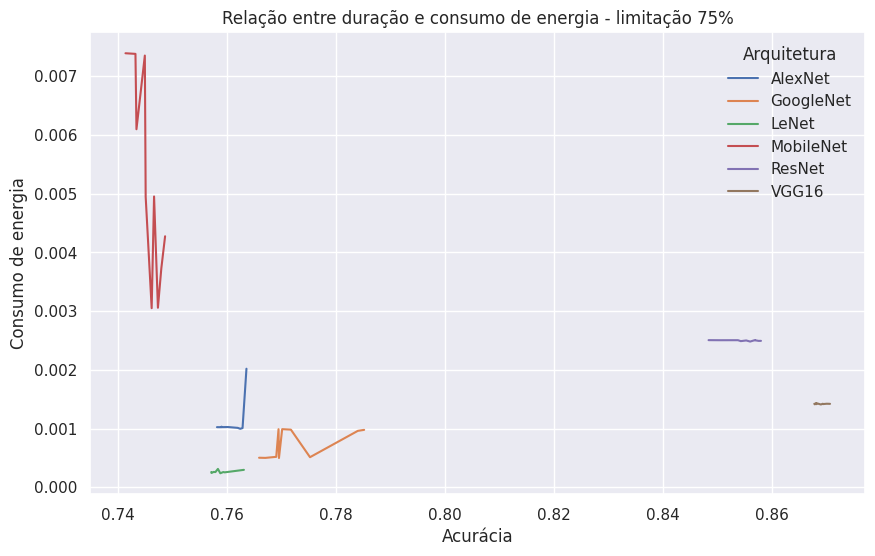

In [ ]:
#Gráfico de linhas de energia consumida e acurácia
plt.figure(figsize=(10, 6))
sns.lineplot(x='Acuracia', y='Energia_kWh', data=dados_75, hue='Arquitetura')
plt.title('Relação entre duração e consumo de energia - limitação 75%')
plt.xlabel('Acurácia')
plt.ylabel('Consumo de energia')
plt.show()

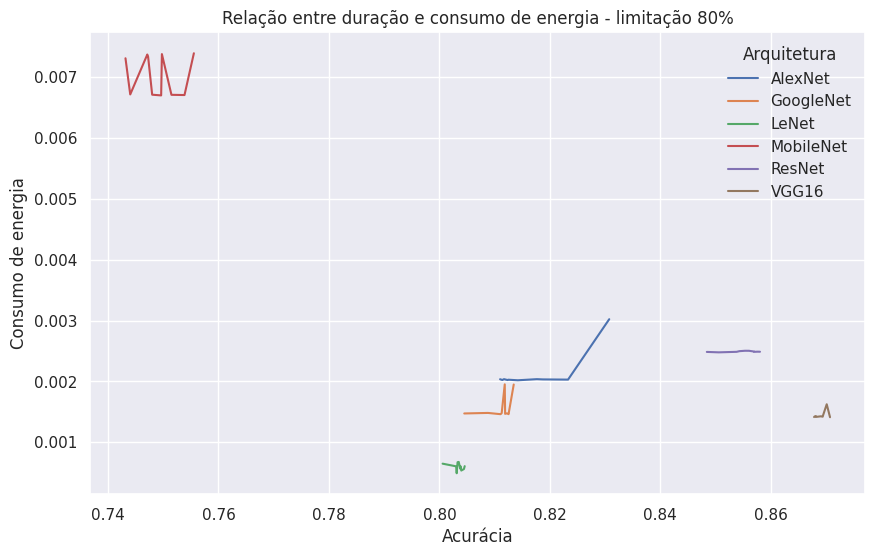

In [ ]:
#Gráfico de linhas de energia consumida e acurácia
plt.figure(figsize=(10, 6))
sns.lineplot(x='Acuracia', y='Energia_kWh', data=dados_80, hue='Arquitetura')
plt.title('Relação entre duração e consumo de energia - limitação 80%')
plt.xlabel('Acurácia')
plt.ylabel('Consumo de energia')
plt.show()

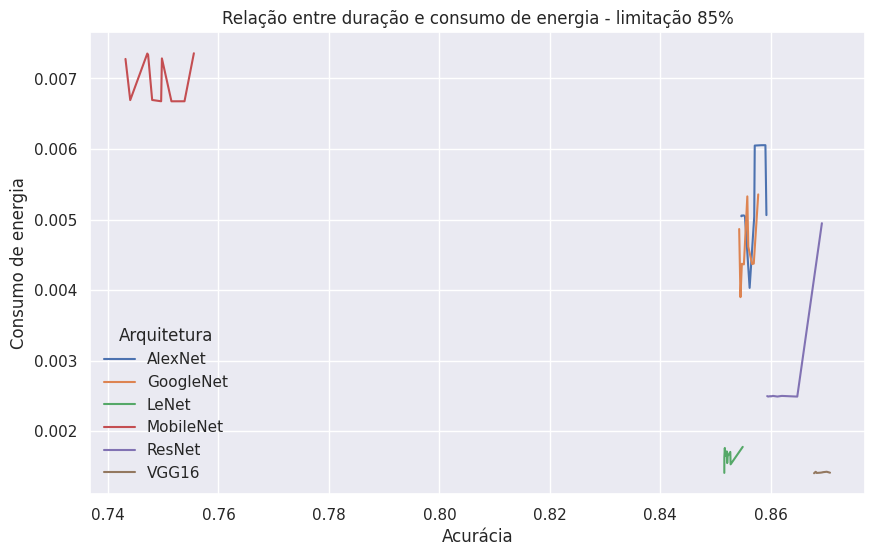

In [ ]:
#Gráfico de linhas de energia consumida e acurácia
plt.figure(figsize=(10, 6))
sns.lineplot(x='Acuracia', y='Energia_kWh', data=dados_85, hue='Arquitetura')
plt.title('Relação entre duração e consumo de energia - limitação 85%')
plt.xlabel('Acurácia')
plt.ylabel('Consumo de energia')
plt.show()

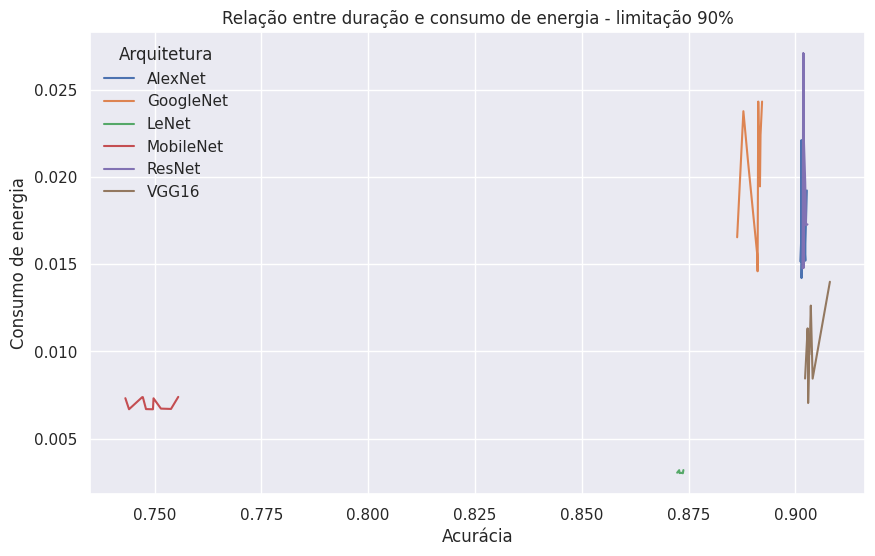

In [ ]:
#Gráfico de linhas de energia consumida e acurácia
plt.figure(figsize=(10, 6))
sns.lineplot(x='Acuracia', y='Energia_kWh', data=dados_90, hue='Arquitetura')
plt.title('Relação entre duração e consumo de energia - limitação 90%')
plt.xlabel('Acurácia')
plt.ylabel('Consumo de energia')
plt.show()

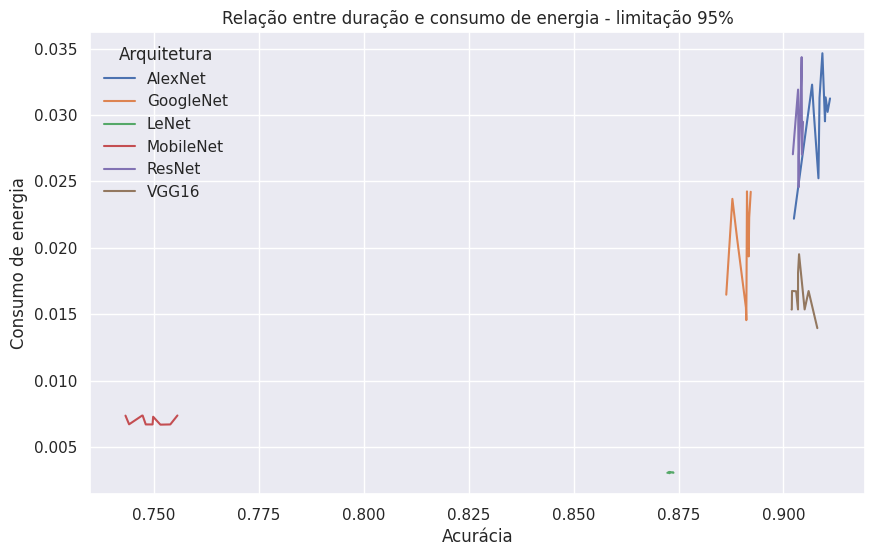

In [ ]:
#Gráfico de linhas de energia consumida e acurácia
plt.figure(figsize=(10, 6))
sns.lineplot(x='Acuracia', y='Energia_kWh', data=dados_95, hue='Arquitetura')
plt.title('Relação entre duração e consumo de energia - limitação 95%')
plt.xlabel('Acurácia')
plt.ylabel('Consumo de energia')
plt.show()

## Eficiência energética

In [ ]:
# Agrupamento por arquitetura: média das execuções
eficiencia_media = dados.groupby('Arquitetura')[['Eficiencia_Energia', 'Eficiencia_Emissao']].mean().sort_values(by='Eficiencia_Energia', ascending=False)

print("Índice médio de eficiência ambiental por arquitetura:")
print(eficiencia_media)

Índice médio de eficiência ambiental por arquitetura:
             Eficiencia_Energia  Eficiencia_Emissao
Arquitetura                                        
LeNet               1534.821768        17536.659878
GoogleNet            507.424441         7443.354185
VGG16                403.417794         6345.940906
AlexNet              315.985728        11043.746614
ResNet               224.235640         2760.057908
MobileNet            144.393399         6830.978527


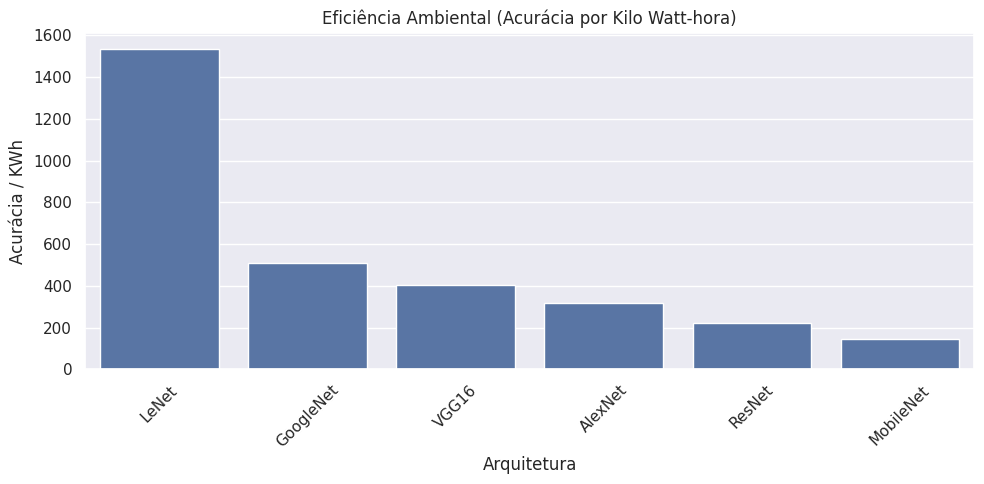

In [ ]:
# Visualização
plt.figure(figsize=(10, 5))
sns.barplot(data=eficiencia_media.reset_index(), x='Arquitetura', y='Eficiencia_Energia')
plt.title("Eficiência Ambiental (Acurácia por Kilo Watt-hora)")
plt.ylabel("Acurácia / KWh")
plt.xlabel("Arquitetura")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

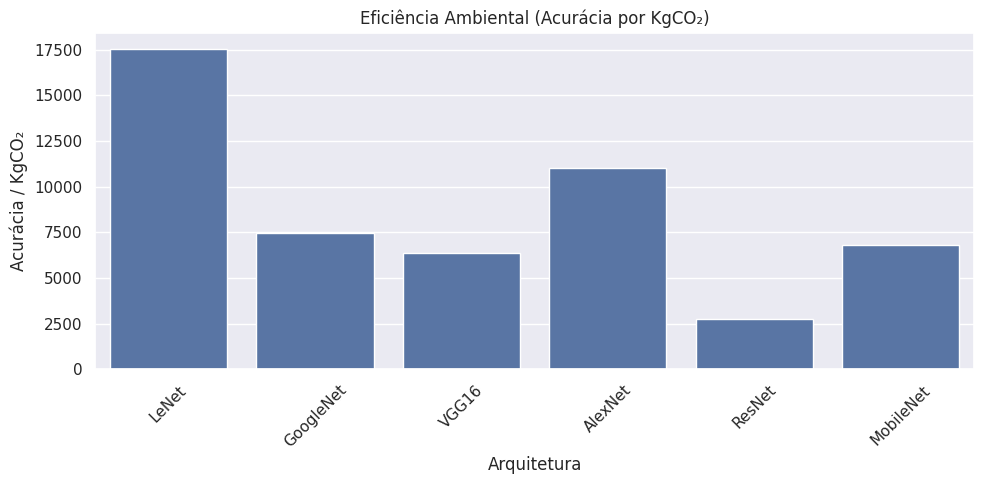

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=eficiencia_media.reset_index(), x='Arquitetura', y='Eficiencia_Emissao')
plt.title("Eficiência Ambiental (Acurácia por KgCO₂)")
plt.ylabel("Acurácia / KgCO₂")
plt.xlabel("Arquitetura")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
eficiencia_media_70 = dados_agrupados_70.groupby('Arquitetura')[['Eficiencia_Energia', 'Eficiencia_Emissao']].mean().sort_values(by='Eficiencia_Energia', ascending=False)
eficiencia_media_75 = dados_agrupados_75.groupby('Arquitetura')[['Eficiencia_Energia', 'Eficiencia_Emissao']].mean().sort_values(by='Eficiencia_Energia', ascending=False)
eficiencia_media_80 = dados_agrupados_80.groupby('Arquitetura')[['Eficiencia_Energia', 'Eficiencia_Emissao']].mean().sort_values(by='Eficiencia_Energia', ascending=False)
eficiencia_media_85 = dados_agrupados_85.groupby('Arquitetura')[['Eficiencia_Energia', 'Eficiencia_Emissao']].mean().sort_values(by='Eficiencia_Energia', ascending=False)
eficiencia_media_90 = dados_agrupados_90.groupby('Arquitetura')[['Eficiencia_Energia', 'Eficiencia_Emissao']].mean().sort_values(by='Eficiencia_Energia', ascending=False)
eficiencia_media_95 = dados_agrupados_95.groupby('Arquitetura')[['Eficiencia_Energia', 'Eficiencia_Emissao']].mean().sort_values(by='Eficiencia_Energia', ascending=False)

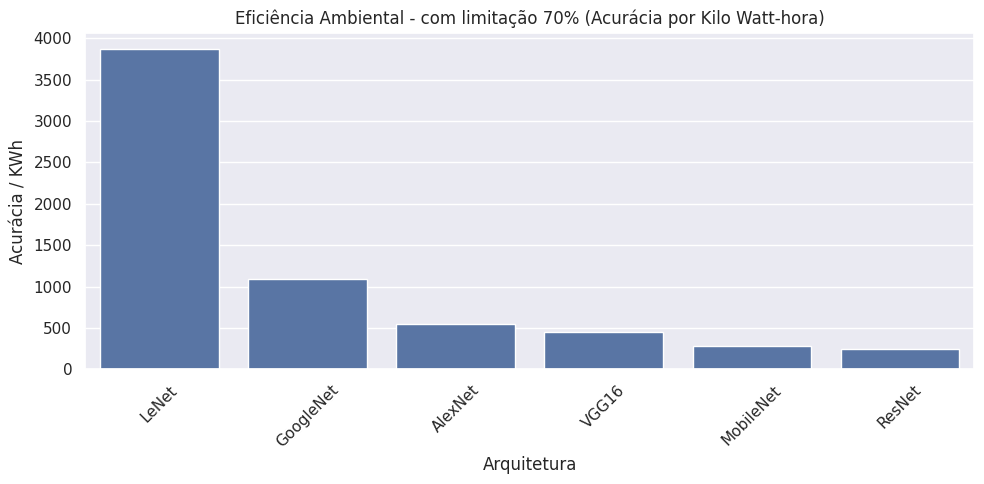

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=eficiencia_media_70.reset_index(), x='Arquitetura', y='Eficiencia_Energia')
plt.title("Eficiência Ambiental - com limitação 70% (Acurácia por Kilo Watt-hora)")
plt.ylabel("Acurácia / KWh")
plt.xlabel("Arquitetura")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

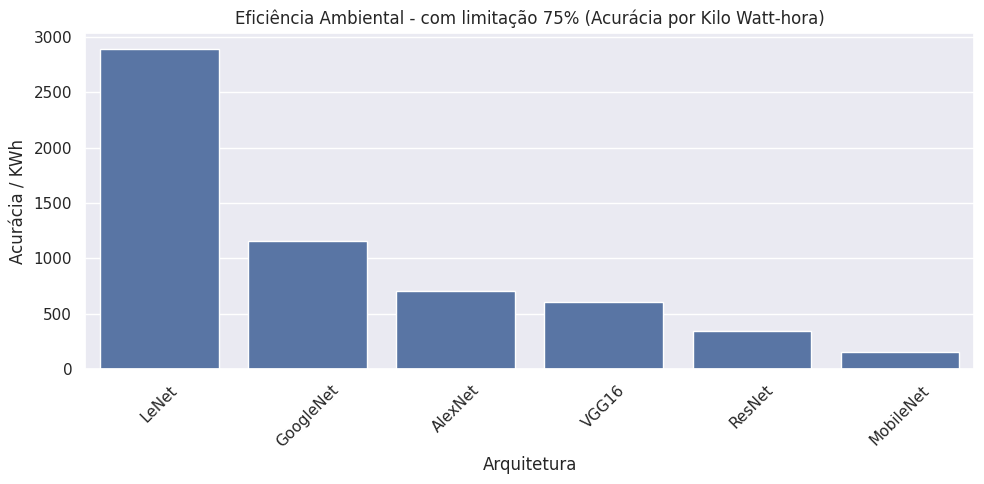

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=eficiencia_media_75.reset_index(), x='Arquitetura', y='Eficiencia_Energia')
plt.title("Eficiência Ambiental - com limitação 75% (Acurácia por Kilo Watt-hora)")
plt.ylabel("Acurácia / KWh")
plt.xlabel("Arquitetura")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

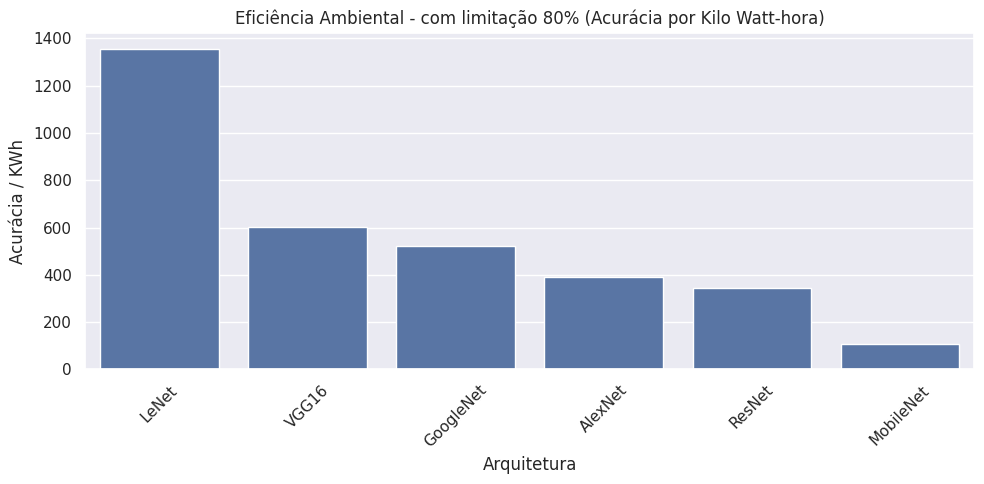

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=eficiencia_media_80.reset_index(), x='Arquitetura', y='Eficiencia_Energia')
plt.title("Eficiência Ambiental - com limitação 80% (Acurácia por Kilo Watt-hora)")
plt.ylabel("Acurácia / KWh")
plt.xlabel("Arquitetura")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

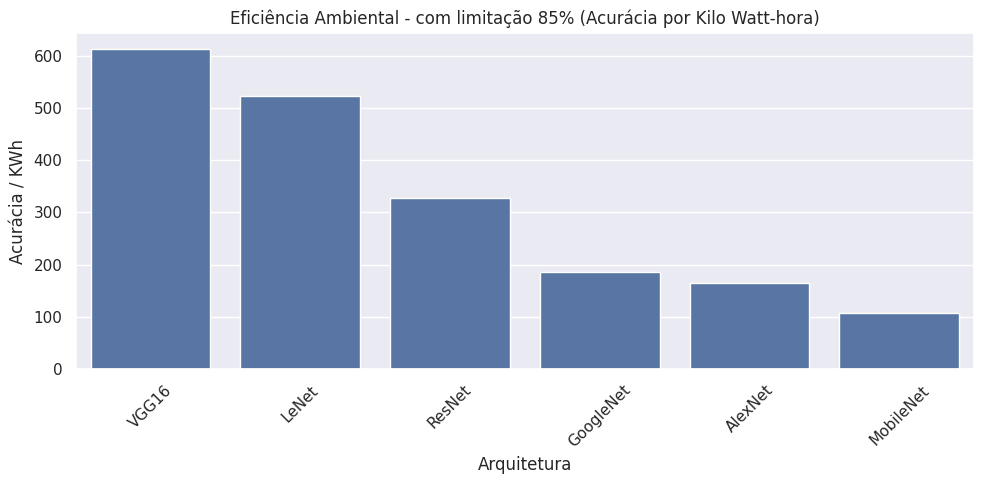

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=eficiencia_media_85.reset_index(), x='Arquitetura', y='Eficiencia_Energia')
plt.title("Eficiência Ambiental - com limitação 85% (Acurácia por Kilo Watt-hora)")
plt.ylabel("Acurácia / KWh")
plt.xlabel("Arquitetura")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

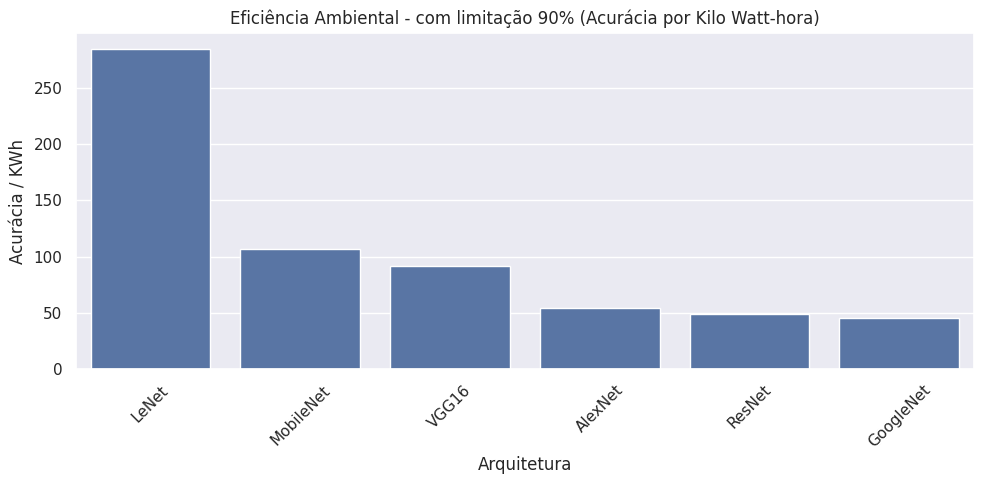

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=eficiencia_media_90.reset_index(), x='Arquitetura', y='Eficiencia_Energia')
plt.title("Eficiência Ambiental - com limitação 90% (Acurácia por Kilo Watt-hora)")
plt.ylabel("Acurácia / KWh")
plt.xlabel("Arquitetura")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

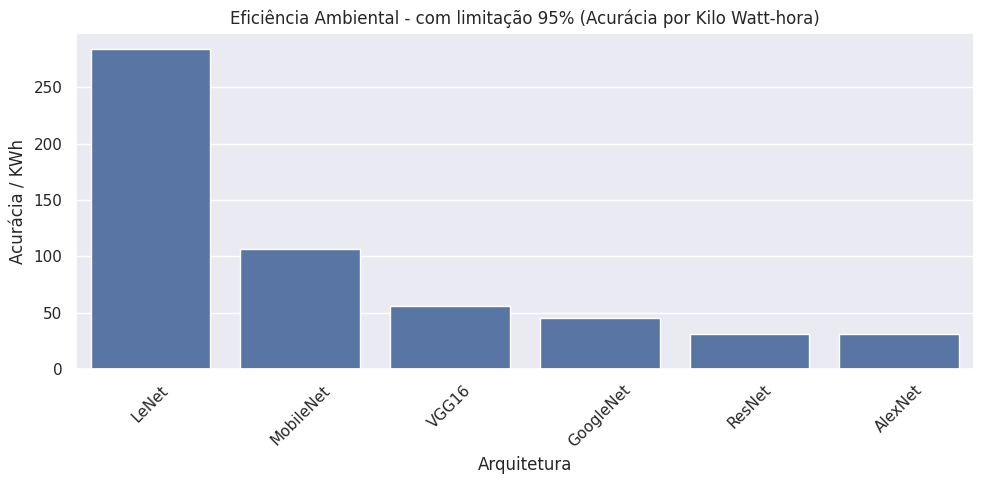

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=eficiencia_media_95.reset_index(), x='Arquitetura', y='Eficiencia_Energia')
plt.title("Eficiência Ambiental - com limitação 95% (Acurácia por Kilo Watt-hora)")
plt.ylabel("Acurácia / KWh")
plt.xlabel("Arquitetura")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()